# **NHL Skating Video Analysis**

## **1: Setup & Import** <a id="functions"></a>

In [72]:
# verify the python version being used is from hockey_ai virtual environment
!which python

/Users/liammckendry/Project3_NHL_Videos/venv310/bin/python


In [73]:
import os  # OS library for interacting with the operating system
import psutil  # psutil library for system monitoring
import sys # sys library for system-specific parameters and functions
import subprocess # subprocess library for running shell commands

import time # time library for time-related functions
from datetime import datetime # datetime library for manipulating dates and times

import numpy as np  # NumPy library for numerical operations
import pandas as pd # Pandas library for data manipulation
import math  # Math library for mathematical functions
from scipy import stats # SciPy library for scientific computing

from pytube import YouTube  # PyTube library for downloading YouTube videos
import yt_dlp  # yt-dlp library for downloading videos from various platforms
import cv2  # OpenCV library for computer vision tasks
import mediapipe as mp  # MediaPipe library for machine learning solutions

import matplotlib.pyplot as plt  # Matplotlib library for data visualization
import seaborn as sns  # Seaborn library for data visualization
from tabulate import tabulate  # Tabulate library for creating tables

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier

import xgboost as xgb

import pickle
import joblib



## **2: Functions** <a id="functions"></a>

### **2.1 Utility Functions** <a id="utility"></a>

In [74]:
# Function to convert time string to seconds
def time_to_seconds(time_str):
        parts = list(map(int, time_str.split(':')))
        if len(parts) == 3:
            return parts[0] * 3600 + parts[1] * 60 + parts[2]
        elif len(parts) == 2:
            return parts[0] * 60 + parts[1]
        elif len(parts) == 1:
            return parts[0]
        else:
            raise ValueError("Invalid time format")

In [75]:
def print_list_of_files_by_size():
    """
    Print the list of files in the current directory sorted by size in descending order
    """
    files = []
    for file in os.listdir():
        files.append((file, os.path.getsize(file)))
    files.sort(key=lambda x: x[1], reverse=True)
    for file in files:
        print(f"{file[0]}: {file[1]} bytes")

print_list_of_files_by_size()  # Print the list of files in the current directory sorted by size

NHL_Videos.ipynb: 3195080 bytes
.DS_Store: 6148 bytes


In [76]:
# Function to print the memory usage of the current environment
def print_memory_usage():
    memory_info = psutil.virtual_memory()
    print(f"Total memory: {memory_info.total / (1024 ** 2):.2f} MB")
    print(f"Used memory: {memory_info.used / (1024 ** 2):.2f} MB")
    print(f"Available memory: {memory_info.available / (1024 ** 2):.2f} MB")
    print(f"Memory usage percentage: {memory_info.percent:.2f}%")
    print(f"CPU usage percentage: {psutil.cpu_percent(interval=1):.2f}%")
    print(f"Number of CPU cores: {psutil.cpu_count()}")
    print(f"Number of threads: {psutil.cpu_count(logical=False)}")
    print(f"Number of logical CPUs: {psutil.cpu_count(logical=True)}")
    print(f"CPU frequency: {psutil.cpu_freq().current:.2f} MHz")

print_memory_usage()  # Print the memory usage of the current environment
    

Total memory: 16384.00 MB
Used memory: 7352.20 MB
Available memory: 5586.62 MB
Memory usage percentage: 65.90%
CPU usage percentage: 15.30%
Number of CPU cores: 10
Number of threads: 10
Number of logical CPUs: 10
CPU frequency: 4.00 MHz


In [77]:
def list_variables():
    """
    Print a detailed list of all variables in the current namespace.
    """
    get_ipython().magic('whos')

In [78]:
def delete_variables(*args):
    """
    Delete all variables or specific variables provided in arguments, and clear garbage.
    
    Parameters:
    *args: List of variable names to delete. If no arguments are provided, all variables will be deleted.
    """
    
    ipython = get_ipython()
    
    if args:
        for var in args:
            if var in ipython.user_ns:
                del ipython.user_ns[var]
                print(f"Deleted variable: {var}")
            else:
                print(f"Variable not found: {var}")
    else:
        ipython.magic('reset -f')
        print("Deleted all variables.")
    
    gc.collect()
    print("Garbage collection complete.")

In [79]:
# function get a list of functions defined in notebook
def printFunctions():
    functions_list = [name for name, obj in globals().items() if callable(obj) and obj.__module__ == '__main__']
    print("📌 Functions Defined in Notebook:")
    print("\n".join(functions_list))

In [80]:
# Function to check dataset structure and print first 5 rows
def checkDataset(df):
    df.info()
    df.head()

In [81]:
#Function to print API response in a readable dictionary so we can investigate the structure
def read_APIResponseStructure(url):
    
    # Fetch game data
    response = requests.get(url)
    data = response.json()

    pp = pprint.PrettyPrinter(depth=4)  # Limits deep nesting
    pp.pprint(data)

In [82]:
# Monitor DataFrame Memory Usage

def show_memory_usage():
    """Displays memory usage of all DataFrames in global scope."""
    for var_name in list(globals()):
        var_value = globals()[var_name]
        if isinstance(var_value, (pd.DataFrame, pd.Series)):  # Check if it's a DataFrame
            print(f"{var_name}: {sys.getsizeof(var_value) / (1024 * 1024):.2f} MB")

In [83]:
# Delete Large DataFrames When No Longer Needed

def delete_dataframe(df):
    del df
    gc.collect()  # Force garbage collection


In [84]:
# Optimize DataFrame Column Types (from 64->32 float or int vars)

def optimize_dataframe(df):
    """Reduce memory usage by downcasting numerical columns."""
    for col in df.select_dtypes(include=['float64']):
        df[col] = df[col].astype('float32')
    for col in df.select_dtypes(include=['int64']):
        df[col] = df[col].astype('int32')
    return df


In [85]:
# remove hidden variables that are taking up memory

def remove_hidden_variables():
    %reset out -f


### **2.2 Video Functions** <a id="video"></a>

In [86]:
def extract_frames_for_videos(video_dict, video_directory, frame_directory, frame_interval):
    """
    Extract frames for videos in the video dictionary and save them to the specified frame directory.

    Parameters:
    video_dict (dict): Dictionary containing video information.
    video_directory (str): Directory containing the video files.
    frame_directory (str): Directory to save the extracted frames.
    frame_interval (int): Interval to extract frames (in seconds).
    """
    for video_id, video_info in video_dict.items():
        video_path = os.path.join(video_directory, video_info['filename'])  # Get the path to the video file
        frame_folder_path = os.path.join(frame_directory, video_info['filename'].split('.')[0])  # Get the path to the frame folder

        if os.path.exists(frame_folder_path):  # Skip if frames already extracted (frame folder exists)
            print(f"Skipping frame extraction, folder already exists: {frame_folder_path}")
            continue

        segments = video_info['segments']  # Get the segments for the video
        os.makedirs(frame_folder_path, exist_ok=True)  # Create the frame folder
        print(f"Extracting frames for video ID: {video_id} from {video_path} into {frame_folder_path}")

        extract_and_save_frames_between_times(video_path, frame_folder_path, frame_interval, segments)
        print(f"Completed extracting frames for video ID: {video_id}")

In [87]:
def check_missing_videos(video_dict, video_directory):
    """
    Check for missing videos between the list of videos in the video dictionary and the list of files in the given video directory.

    Parameters:
    video_dict (dict): Dictionary containing video information.
    video_directory (str): Directory containing the video files.

    Returns:
    bool: True if there are missing videos, False otherwise.
    """
    # Check if the video directory exists
    if not os.path.exists(video_directory):
        print(f"Error: Video directory '{video_directory}' not found.")
        return True

    # Get the list of video filenames from the video dictionary and convert to lowercase
    video_filenames = [info['filename'].lower() for info in video_dict.values()]
    print(f"Video filenames from dictionary: {video_filenames}")

    # Get the list of files in the video directory and convert to lowercase
    directory_files = [file.lower() for file in os.listdir(video_directory)]
    print(f"Files in video directory: {directory_files}")

    # Check for missing videos
    missing_videos = [filename for filename in video_filenames if filename not in directory_files]
    print(f"Missing videos: {missing_videos}")

    if missing_videos:
        print(f"Missing videos: {missing_videos}")
        return True
    else:
        print("No missing videos.")
        return False

In [88]:
def process_and_save_skating_metrics(video_dict, frame_directory, pose_estimates_by_video, skating_metrics, csv_output_path_metrics):
    """
    Process skating metrics for each video and save the combined metrics to a CSV file.

    Parameters:
    video_dict (dict): Dictionary containing video information.
    frame_directory (str): Directory containing the video frames.
    pose_estimates_by_video (dict): Dictionary containing pose estimates for each video.
    skating_metrics (list): List of skating metrics to calculate.
    csv_output_path_metrics (str): Path to save the output CSV file.
    """
    df_combined = pd.DataFrame()  # Initialize an empty DataFrame to store combined metrics

    for video_id, video_info in video_dict.items():
        video_file = video_info['filename'].split('.')[0]
        frame_folder_path = os.path.join(frame_directory, video_file)
        if not os.path.exists(frame_folder_path):
            print(f"Frame folder does not exist: {frame_folder_path}")
            continue

        pose_folder_path = os.path.join(frame_directory, f"pose_output_{video_file}")
        pose_estimates = pose_estimates_by_video[video_id]
        frame_time = 1 / video_info['fps']
        print(f"Processing video ID: {video_id}, Frame folder: {frame_folder_path}, Pose folder: {pose_folder_path}")
        print(f"Number of pose estimates: {len(pose_estimates)}, Frame time: {frame_time}")

        df_skating = calculate_metrics(pose_estimates, frame_time, skating_metrics, video_info)
        print(f"Metrics calculated for video ID: {video_id}, Number of rows: {len(df_skating)}")

        df_skating = calculate_time_series_metrics(df_skating)
        print(f"Time series metrics calculated for video ID: {video_id}, Number of rows: {len(df_skating)}")

        if df_combined.empty:
            df_combined = df_skating
        else:
            df_combined = pd.concat([df_combined, df_skating], ignore_index=True)
        print(f"Metrics combined for video ID: {video_id}, Total rows in combined DataFrame: {len(df_combined)}")

    df_combined.to_csv(csv_output_path_metrics, index=False)  # Save the combined DataFrame to a CSV file
    print(f"Skating metrics saved to {csv_output_path_metrics}")

    return df_combined

In [89]:
def process_pose_estimates(video_dict, frame_directory):
    """
    Process pose estimates for each video in the video dictionary.

    Parameters:
    video_dict (dict): Dictionary containing video information.
    frame_directory (str): Directory containing the frames.

    Returns:
    dict: Dictionary containing pose estimates by video ID and frame ID.
    """
    pose_estimates_by_video = {}

    for video_id, video_info in video_dict.items():
        frame_folder_path = os.path.join(frame_directory, video_info['filename'].split('.')[0])
        if not os.path.exists(frame_folder_path):
            print(f"Frame folder does not exist: {frame_folder_path}")
            continue

        pose_folder_path = os.path.join(frame_directory, f"pose_output_{video_id+1}")
        print(f"Processing video ID: {video_id}, Frame folder: {frame_folder_path}, Pose folder: {pose_folder_path}")

        pose_estimates = get_pose_landmarks(frame_folder_path)
        pose_estimates_by_video[video_id] = pose_estimates  # Store pose estimates by video ID
        print(f"Pose estimates calculated for video_{video_id}, Number of pose estimates: {len(pose_estimates)}")

        if not os.path.exists(pose_folder_path) or not os.listdir(pose_folder_path):
            draw_pose_landmarks(pose_estimates, frame_folder_path, pose_folder_path)
            print(f"Pose landmarks for video_{video_id} saved to: {pose_folder_path}. Number of pose estimates: {len(pose_estimates)}")
        else:
            print(f"Skipping pose landmarks for video_{video_id}, pose output already exists in: {pose_folder_path}. Number of pose estimates: {len(pose_estimates)}")

    return pose_estimates_by_video


In [90]:
def extract_and_save_frames_between_times(video_path, frame_folder_path, k, segments):
    """
    Extract and save every k-th frame from a video for multiple specified segments.

    Parameters:
    video_path (str): Path to the video file.
    frame_folder_path (str): Path to the folder where frames will be saved.
    k (int): Interval of frames to save (e.g., save every k-th frame).
    segments (list): List of dictionaries containing start and end times in hh:mm:ss, mm:ss, or ss format.
    """
    
    # Create folder for video frames if it doesn't exist
    os.makedirs(frame_folder_path, exist_ok=True)
    print(f"Created directory {frame_folder_path} for saving frames.")

    # Open the video file using OpenCV (cv2) library
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_path}")
        return
    fps = cap.get(cv2.CAP_PROP_FPS)  # Get frames per second
    print(f"Video {video_path} opened successfully with {fps} FPS.")

    for segment in segments:
        start_time = segment['start_time']
        end_time = segment['end_time']
        
        # Convert start and end times to seconds
        start_time_sec = time_to_seconds(start_time)
        end_time_sec = time_to_seconds(end_time)
        print(f"Processing segment from {start_time} to {end_time} ({start_time_sec} to {end_time_sec} seconds).")

        start_frame = int(start_time_sec * fps)  # Calculate start frame
        end_frame = int(end_time_sec * fps)  # Calculate end frame
        frame_count = 0  # Initialize frame count

        # Set the starting frame of the video
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        print(f"Set video position to start frame {start_frame}.")

        while cap.isOpened():  # Loop until the video is opened
            ret, frame = cap.read()  # Read a frame from the video
            if not ret or frame_count > end_frame - start_frame:  # If no frame is returned or end frame is reached, break the loop
                print(f"End of segment reached or no frame returned. Breaking loop.")
                break

            # Save every k-th frame
            if frame_count % k == 0:  # Check if the frame count is a multiple of k
                frame_filename = f"{frame_folder_path}/frame_{start_frame + frame_count}.jpg"  # Create a filename for the frame
                if not os.path.exists(frame_filename):  # Check if the frame file already exists
                    cv2.imwrite(frame_filename, frame)  # Save the frame as an image
                    print(f"Saved frame {start_frame + frame_count} to {frame_filename}.")
                else:
                    print(f"Skipping {frame_filename}, already exists.")

            frame_count += 1  # Increment the frame count

    cap.release()  # Release the video capture object

In [91]:
def download_missing_videos(video_dict, output_directory):
    """
    Download videos from the video dictionary that have a URL and do not exist in the output directory.

    Parameters:
    video_dict (dict): Dictionary containing video information.
    output_directory (str): Directory to save the downloaded videos.
    """
    # Iterate through the video dictionary
    for video_id, video_info in video_dict.items():
        video_path = os.path.join(output_directory, video_info['filename'])
        if video_info.get('url') and not os.path.exists(video_path):
            print(f"Downloading video: {video_info['url']} to {video_path}")
            download_video(video_info['url'], video_path)
            print(f"Downloaded video: {video_info['filename']}")
        else:
            print(f"Skipping video: {video_info['filename']} (already exists or no URL)")

In [92]:
def load_video_dict(csv_file_path):
    """
    Load video dictionary from a CSV file.

    Parameters:
    csv_file_path (str): Path to the CSV file.

    Returns:
    dict: Dictionary containing video information.
    """
    print(f"Loading video dictionary from {csv_file_path}...")
    if os.path.exists(csv_file_path):
        df = pd.read_csv(csv_file_path)
        video_dict = df.to_dict(orient='index')
        print("Video dictionary loaded successfully.")
    else:
        video_dict = {}
        print("CSV file not found. Returning an empty dictionary.")
    return video_dict

def save_video_dict(video_dict, csv_file_path):
    """
    Save video dictionary to a CSV file.

    Parameters:
    video_dict (dict): Dictionary containing video information.
    csv_file_path (str): Path to the CSV file.
    """
    print(f"Saving video dictionary to {csv_file_path}...")
    df = pd.DataFrame.from_dict(video_dict, orient='index')
    df.to_csv(csv_file_path, index=False)
    print(f"Video dictionary saved to {csv_file_path}")

def add_new_videos(video_dict, new_videos):
    """
    Add new video entries to the video dictionary.

    Parameters:
    video_dict (dict): Dictionary containing existing video information.
    new_videos (list): List of dictionaries containing new video information.
    """
    print("Adding new videos to the dictionary...")
    existing_filenames = {info['filename'] for info in video_dict.values()}
    
    for video_info in new_videos:
        if video_info['filename'] in existing_filenames:
            print(f"Error: Video with filename {video_info['filename']} already exists in the dictionary. Skipping.")
            continue
        video_id = max(video_dict.keys(), default=-1) + 1
        video_dict[video_id] = video_info
        print(f"Added {video_info['filename']} as {video_id}.")
    return video_dict

def remove_video(video_dict, video_id):
    """
    Remove a video entry from the video dictionary.

    Parameters:
    video_dict (dict): Dictionary containing video information.
    video_id (str): ID of the video to remove.
    """
    if video_id in video_dict:
        del video_dict[video_id]
        print(f"Removed video with ID {video_id}.")
    else:
        print(f"Video ID {video_id} not found in the dictionary.")
    return video_dict

def print_video_dict(video_dict):
    """
    Print the current video dictionary in a readable format.

    Parameters:
    video_dict (dict): Dictionary containing video information.
    """
    print("Current video dictionary:")
    for video_id, video_info in video_dict.items():
        print(f"{video_id}: {video_info}")

In [93]:
def extract_frames_from_videos(video_folder, frame_folder, video_times, k):
    """
    Extract frames from videos between specified start and end times and save them to a folder.

    Parameters:
    video_folder (str): Path to the folder containing video files.
    frame_folder (str): Path to the folder where frames will be saved.
    video_times (list): List of dictionaries with video filenames and start/end times.
    k (int): Interval of frames to save (e.g., save every k-th frame).
    """
    for video_info in video_times:
        video_path = os.path.join(video_folder, video_info['filename'])
        start_time = video_info['start_time']
        end_time = video_info['end_time']
        extract_and_save_frames_between_times(video_path, frame_folder, k, start_time, end_time)


In [94]:
def download_video_between_times(youtube_url, output_path, start_time=None, end_time=None):
    """
    Download a video from YouTube using yt-dlp and trim it with ffmpeg.
    
    Parameters:
    youtube_url (str): URL of the YouTube video to download.
    output_path (str): Path to save the trimmed video.
    start_time (str): Start time in the format "HH:MM:SS" or "MM:SS" or "SS".
    end_time (str): End time in the format "HH:MM:SS" or "MM:SS" or "SS".
    """
    # Define yt-dlp options
    temp_output = output_path.replace(".mp4", "_full.mp4")  # Temporary file to store full video
    
    ydl_opts = {
        "format": "bestvideo+bestaudio/best",  # Best quality
        "merge_output_format": "mp4",  # Ensure MP4 output
        "outtmpl": temp_output,  # Temporary output file
        "ffmpeg_location": "/opt/homebrew/bin/ffmpeg"  # Adjust ffmpeg path if needed
    }

    try:
        # Download full video
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([youtube_url])

        print("Video downloaded successfully!")

        # If start and end times are provided, trim the video
        if start_time or end_time:
            trim_video(temp_output, output_path, start_time, end_time)
            os.remove(temp_output)  # Remove the full video after trimming
        else:
            os.rename(temp_output, output_path)  # Keep full video if no trimming needed

    except Exception as e:
        print(f"An error occurred: {e}")

def trim_video(input_path, output_path, start_time, end_time):
    """
    Trim the downloaded video using ffmpeg.
    
    Parameters:
    input_path (str): Path of the full downloaded video.
    output_path (str): Path of the trimmed video.
    start_time (str): Start time (format: "HH:MM:SS" or "MM:SS" or "SS").
    end_time (str): End time (format: "HH:MM:SS" or "MM:SS" or "SS").
    """
    command = [
        "/opt/homebrew/bin/ffmpeg", "-i", input_path,
        "-ss", start_time,  # Start time
        "-to", end_time,  # End time
        "-c", "copy",  # Copy streams (faster trimming)
        output_path,  # Output file
        "-y"  # Overwrite existing file
    ]
    
    subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print(f"Trimmed video saved to {output_path}")

In [95]:
def download_videos(url_list, output_dir):
    """
    Download a set of videos from YouTube using yt-dlp.

    Parameters:
    url_list (list): List of YouTube video URLs to download.
    output_dir (str): Directory to save the downloaded videos.
    """
    for i, video_info in enumerate(url_list):
        youtube_url = video_info['url']
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_path = os.path.join(output_dir, f"{timestamp}_{video_info['type']}.mp4")
        try:
            download_video(youtube_url, output_path)
            print(f"Downloaded {youtube_url} to {output_path}")
        except Exception as e:
            print(f"Failed to download {youtube_url}: {e}")

In [96]:
def process_videos_and_extract_frames(video_dict, output_folder, frame_interval):
    """
    Process videos by downloading from YouTube if necessary and extracting frames.

    Parameters:
    video_dict (dict): Dictionary containing video information. Keys are video IDs, values are dictionaries with 'url', 'type', 'filename', 'start_time', and 'end_time'.
    output_folder (str): Path to the folder where videos and frames will be saved.
    frame_interval (int): Interval of frames to save (e.g., save every k-th frame).
    """
    # Separate YouTube videos and already downloaded videos
    youtube_videos = []
    local_videos = []

    for video_id, video_info in video_dict.items():
        video_path = os.path.join(output_folder, video_info['filename'])
        if 'url' in video_info:
            if not os.path.exists(video_path):
                youtube_videos.append(video_info)
            else:
                local_videos.append(video_info)
        else:
            local_videos.append(video_info)

    # Download YouTube videos
    if youtube_videos:
        for video_info in youtube_videos:
            print(f"Downloading video: {video_info['url']}")
            download_video_between_times(
                video_info['url'],
                os.path.join(output_folder, video_info['filename']),
                video_info.get('start_time'),
                video_info.get('end_time')
            )
            print(f"Downloaded video: {video_info['filename']}")

    # Extract frames from all videos in the folder
    for video_info in local_videos:
        video_path = os.path.join(output_folder, video_info['filename'])
        frame_folder = os.path.join(output_folder, f"frames_{video_info['filename'].split('.')[0]}")
        if not os.path.exists(frame_folder):
            print(f"Extracting frames from video: {video_info['filename']}")
            extract_and_save_frames_between_times(
                video_path,
                frame_folder,
                frame_interval,
                video_info.get('start_time', 0),
                video_info.get('end_time', float('inf'))
            )
            print(f"Extracted frames for video: {video_info['filename']}")
        else:
            print(f"Skipping frame extraction, folder already exists: {frame_folder}")

In [97]:
def process_videos(url_list, output_dir, frame_interval, metrics, start_index):
    """
    Process a list of YouTube video URLs: download, extract frames, get pose landmarks, and calculate metrics.
    
    Parameters:
    url_list (list): List of YouTube video URLs.
    output_dir (str): Directory to save downloaded videos and frames.
    frame_interval (int): Interval of frames to save (e.g., save every k-th frame).
    metrics (list): List of metrics to calculate.
    """
    df_combined = pd.DataFrame()  # Initialize an empty DataFrame to store combined metrics
    
    for i, video_info in enumerate(url_list):
        
        
        try:
            print(f"Processing video {i + start_index}/{len(url_list)}: {video_info['url']}")

            # Step 1: Download the video if it doesn't already exist
            video_output_path = os.path.join(output_dir, f"video_{i + start_index}.mp4")
            if not os.path.exists(video_output_path):
                youtube_url = video_info['url'] # Get the YouTube video URL
                download_video(youtube_url, video_output_path)
                print(f"Video downloaded to: {video_output_path}")
            else:
                print(f"Skipping download, video already exists: {video_output_path}")
            
            # Step 2: Retrieve and print video properties
            duration, total_frames, fps = get_video_properties(video_output_path)
            print(f"Video Length: {duration:.2f} seconds, Total Frames: {total_frames}, FPS: {fps}")
            
            # Step 3: Extract and save frames if the folder doesn't already exist
            frame_folder_path = os.path.join(output_dir, f"frames_{i+start_index}")
            if not os.path.exists(frame_folder_path) or not os.listdir(frame_folder_path):
                extract_and_save_frames(video_output_path, frame_folder_path, frame_interval)
                print(f"Frames for video_{i + start_index} saved to: {frame_folder_path}. Number of frames: {len(os.listdir(frame_folder_path))}")
            else:
                print(f"Skipping frame extraction for video_{i + start_index}, frames already exist in: {frame_folder_path}.  Number of frames: {len(os.listdir(frame_folder_path))}")
            
            # Step 4: Get and draw pose landmarks if the folder doesn't already exist
            pose_folder_path = os.path.join(output_dir, f"pose_output_{i + start_index}")
            pose_estimates = get_pose_landmarks(frame_folder_path)
            if not os.path.exists(pose_folder_path) or not os.listdir(pose_folder_path):
                draw_pose_landmarks(pose_estimates, frame_folder_path, pose_folder_path)
                print(f"Pose landmarks for video_{i + start_index} saved to: {pose_folder_path}.  Number of pose estimates: {len(pose_estimates)}")
            else:
                print(f"Skipping pose landmarks for video_{i + start_index}, pose output already exists in: {pose_folder_path}. Number of pose estimates: {len(pose_estimates)}")

            # Step 5: Add video information for context in dataset (in addition to url and type already in video_info)
            video_info['video_id'] = f"video_{i + start_index}"
            video_info['duration'] = duration
            video_info['total_frames'] = total_frames
            video_info['fps'] = fps
            print(f"Video information added for video {i + start_index}/{len(url_list)}")
            
            # Step 6: Calculate pose metrics and save to the DataFrame
            frame_time = 1 / fps
            print("Initiating metrics calculation...")
            print(f"shape of video_info: {video_info}")
            df_skating = calculate_metrics(pose_estimates, frame_time, metrics, video_info)
            print(f"Metrics calculated for video {i + start_index}/{len(url_list)}")
            
            # Step 7: Add time series metrics and Calculate pose metrics and save to the DataFrame
            print("Initiating time series metrics calculation...")
            df_skating = calculate_time_series_metrics(df_skating)
            print(f"Time series metrics calculated for video {i + start_index}/{len(url_list)}")
            
            # Step 8: Combine metrics from all videos
            if df_combined.empty:
                df_combined = df_skating
            else:
                df_combined = pd.concat([df_combined, df_skating], ignore_index=True)
            print(f"Metrics combined for video {i + start_index}/{len(url_list)}.  Total metrics: {len(df_combined)}")
            
            # Step 9: Print completion message
            print(f"Processing complete for video {i + start_index}/{len(url_list)}")
            
        except Exception as e:
            print(f"An error occurred while processing video {i+start_index}/{len(url_list)}: {e}")
    
    # Display the first few rows of the combined metrics DataFrame
    print("Metrics:")
    print(df_combined.head())
    
    return df_combined


In [98]:
def calculate_time_series_metrics(df_skating):
    """
    Calculate time series metrics and update the DataFrame with new columns.

    Parameters:
    df_skating (pd.DataFrame): DataFrame containing skating metrics.

    Returns:
    pd.DataFrame: Updated DataFrame with new time series metrics columns.
    """
    # Calculate velocity change (difference between frames)
    df_skating['velocity_change'] = df_skating['velocity'].diff()

    # Calculate acceleration change (difference between frames)
    df_skating['acceleration_change'] = df_skating['acceleration'].diff()

    # Calculate stride consistency (rolling mean of 5 stride lengths)
    df_skating['stride_consistency'] = df_skating['stride_length'].rolling(window=5).mean()

    # Calculate cadence stability (rolling standard deviation of 10 stride cadence)
    df_skating['cadence_stability'] = df_skating['stride_cadence'].rolling(window=10).std()

    # Calculate knee stability (rolling variance of 5 knee angles)
    df_skating['knee_stability'] = df_skating['knee_angle'].rolling(window=5).var()

    # 🔹 Step 7: Handle Missing Values (from Rolling Window Operations)
    df_skating.fillna(0, inplace=True)  # Fill NaN values with 0

    return df_skating

In [99]:
def checkForNewVideos(skating_video_url_list,df_skating_metrics):
    # Check if all URLs are already processed
    # If not, process the remaining videos (filters video_info where url in skating_video_url_list not in df_skating_metrics)
    urls_in_csv = df_skating_metrics['video_url'].unique()
    urls_to_process = [video_info for video_info in skating_video_url_list if video_info['url'] not in urls_in_csv]
    current_video_count = len(urls_in_csv)
    return urls_to_process, current_video_count

In [100]:
def download_video(youtube_url, output_path):
    """
    Download a video from YouTube using yt-dlp.

    Parameters:
    youtube_url (str): URL of the YouTube video to download.
    output_path (str): Path to save the downloaded video.
    """
    # Define options for yt-dlp
    ydl_opts = {
        "format": "bestvideo+bestaudio/best",  # Download the best video and audio quality available
        "merge_output_format": "mp4",  # Ensure video and audio are merged into an MP4 file
        "outtmpl": output_path,  # Set the output file path
        "ffmpeg_location": "/opt/homebrew/bin/ffmpeg"  # Specify the location of the ffmpeg executable
    }

    try:
        # Create a YoutubeDL object with the specified options
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            # Download the video from the provided URL
            ydl.download([youtube_url])
        print("Video downloaded successfully!")
    except Exception as e:
        # Print an error message if an exception occurs
        print(f"An error occurred: {e}")

In [101]:
def get_video_fps(video_path):
    """
    Get the frames per second (FPS) of a video using OpenCV.

    Parameters:
    video_path (str): Path to the video file.

    Returns:
    float: Frames per second (FPS) of the video.
    """
    # Initialize a VideoCapture object
    video_capture = cv2.VideoCapture(video_path)

    # Get the frames per second (FPS) of the video
    fps = video_capture.get(cv2.CAP_PROP_FPS)

    # Release the VideoCapture object
    video_capture.release()

    return fps

In [102]:
def get_video_properties(video_path):
    """
    Get the video length, total number of frames, and frames per second (FPS).

    Parameters:
    video_path (str): Path to the video file.

    Returns:
    tuple: A tuple containing video length (float), total number of frames (int), and frames per second (float).
    """
    # Open the video file using OpenCV (cv2) library
    cap = cv2.VideoCapture(video_path)

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
    frame_count_total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total number of frames
    duration = frame_count_total / fps  # Duration in seconds

    return duration, frame_count_total, fps


In [103]:
def extract_and_save_frames(video_path, frame_folder_path, k):
    """
    Extract and save every k-th frame from a video.

    Parameters:
    video_path (str): Path to the video file.
    frame_folder_path (str): Path to the folder where frames will be saved.
    k (int): Interval of frames to save (e.g., save every k-th frame).
    """
    # Create folder for video frames if it doesn't exist
    os.makedirs(frame_folder_path, exist_ok=True)

    # Open the video file using OpenCV (cv2) library
    cap = cv2.VideoCapture(video_path)
    frame_count = 0  # Initialize frame count

    while cap.isOpened():  # Loop until the video is opened
        ret, frame = cap.read()  # Read a frame from the video
        if not ret:  # If no frame is returned, break the loop
            break

        # Save every k-th frame
        if frame_count % k == 0:  # Check if the frame count is a multiple of k
            frame_filename = f"{frame_folder_path}/frame_{frame_count}.jpg"  # Create a filename for the frame
            if not os.path.exists(frame_filename):  # Check if the frame file already exists
                cv2.imwrite(frame_filename, frame)  # Save the frame as an image
            else:
                print(f"Skipping {frame_filename}, already exists.")

        frame_count += 1  # Increment the frame count

    cap.release()  # Release the video capture object
    print("Frames extracted successfully!")  # Print success message



In [104]:
def get_pose_landmarks(frame_folder_path):
    """
    Return an array of pose landmarks for each frame.

    Parameters:
    frame_folder_path (str): Path to the folder containing video frames.

    Returns:
    list: A list of tuples containing frame name and pose landmarks.
    """
    # Initialize MediaPipe Pose solution
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)
    
    # Define valid image extensions
    VALID_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')

    # List to store pose estimates
    pose_estimates = []

    # Iterate over each frame in the folder
    for frame_name in os.listdir(frame_folder_path):
        frame_path = os.path.join(frame_folder_path, frame_name)
        
        # Skip files that do not have valid image extensions
        if not frame_name.lower().endswith(VALID_EXTENSIONS):
            continue

        # Read the frame image
        frame = cv2.imread(frame_path)
        if frame is None:
            continue

        # Convert the image from BGR to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Process the image to get pose landmarks
        results = pose.process(rgb_frame)
        
        # If pose landmarks are detected, append them to the list
        if results.pose_landmarks:
            pose_estimates.append((frame_name, results.pose_landmarks))

    # Release MediaPipe Pose solution at the end of the function
    pose.close()
    del pose

    return pose_estimates

In [105]:
def draw_pose_landmarks(pose_estimates, frame_folder_path, pose_folder_path):
    """
    Create drawings of pose landmarks on each frame and store images in a new folder.

    Parameters:
    pose_estimates (list): A list of tuples containing frame name and pose landmarks.
    frame_folder_path (str): Path to the folder containing video frames.
    pose_folder_path (str): Path to the folder to save frames with pose landmarks.
    """
    mp_drawing = mp.solutions.drawing_utils  # MediaPipe drawing utilities for drawing landmarks
    os.makedirs(pose_folder_path, exist_ok=True)  # Create the output folder if it doesn't exist

    for frame_name, pose_landmarks in pose_estimates:
        frame_path = os.path.join(frame_folder_path, frame_name)  # Path to the original frame
        output_path = os.path.join(pose_folder_path, frame_name.replace(".jpg", "_landmark.jpg"))  # Path to save the frame with landmarks
        
        if os.path.exists(output_path):  # Skip processing if the output file already exists
            print(f"Skipping {output_path}, already exists.")
            continue

        frame = cv2.imread(frame_path)  # Read the frame image
        if frame is None:  # Skip if the frame could not be read
            continue

        mp_drawing.draw_landmarks(frame, pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS)  # Draw pose landmarks on the frame
        cv2.imwrite(output_path, frame)  # Save the frame with landmarks to the output path


In [106]:
def count_frames_with_landmarks(pose_estimates):
    """
    Return the number of frames with pose landmarks.

    Parameters:
    pose_estimates (list): A list of tuples containing frame name and pose landmarks.

    Returns:
    int: The number of frames with pose landmarks.
    """
    return len(pose_estimates)

In [107]:
# analyze skating metrics - measure knee bend angle

def calculate_angle(a, b, c):
    """
    Calculate angle between three points (a, b, c).
    a, b, c are tuples of (x, y) coordinates.
    """
    # Vector from point a to point b
    ab = np.array([a[0] - b[0], a[1] - b[1]])
    # Vector from point c to point b
    bc = np.array([c[0] - b[0], c[1] - b[1]])

    # Calculate the cosine of the angle using dot product and magnitudes of vectors
    cosine_angle = np.dot(ab, bc) / (np.linalg.norm(ab) * np.linalg.norm(bc))
    # Calculate the angle in degrees
    angle = np.degrees(np.arccos(cosine_angle))
    return angle

# Example usage:
# Define points a, b, and c as tuples of (x, y) coordinates
a = (0.5, 0.5)
b = (0.5, 0.6)
c = (0.6, 0.6)

# Calculate the angle between points a, b, and c
angle = calculate_angle(a, b, c)
print(f"The angle between points a, b, and c is {angle:.2f} degrees.")

The angle between points a, b, and c is 90.00 degrees.


In [108]:
def calculate_knee_angles(pose_estimates):
    """
    Calculate knee angles for a set of frame pose estimates.

    Parameters:
    pose_estimates (list): A list of tuples containing frame name and pose landmarks.

    Returns:
    list: A list of tuples containing frame name and knee angle.
    """
    knee_angles = []  # Initialize an empty list to store knee angles
    for frame_name, pose_estimate in pose_estimates:  # Iterate over each frame and its pose estimate
        # Extract landmarks for hip, knee, and ankle
        landmarks = pose_estimate.landmark  # Get the landmarks from the pose estimate
        hip = (landmarks[mp.solutions.pose.PoseLandmark.LEFT_HIP].x, landmarks[mp.solutions.pose.PoseLandmark.LEFT_HIP].y)  # Get hip coordinates
        knee = (landmarks[mp.solutions.pose.PoseLandmark.LEFT_KNEE].x, landmarks[mp.solutions.pose.PoseLandmark.LEFT_KNEE].y)  # Get knee coordinates
        ankle = (landmarks[mp.solutions.pose.PoseLandmark.LEFT_ANKLE].x, landmarks[mp.solutions.pose.PoseLandmark.LEFT_ANKLE].y)  # Get ankle coordinates
        
        # Calculate knee bend angle
        knee_angle = calculate_angle(hip, knee, ankle)  # Calculate the angle between hip, knee, and ankle
        knee_angles.append((frame_name, knee_angle))  # Append the frame name and knee angle to the list
    return knee_angles  # Return the list of knee angles


In [109]:
def get_landmarks(pose_estimates, *landmark_names):
    """
    Return specified landmarks for a set of frame pose estimates.

    Parameters:
    pose_estimates (list): A list of tuples containing frame name and pose landmarks.
    *landmark_names (str): Names of landmarks to extract (e.g., 'left_hip', 'right_hip').

    Returns:
    list: A list of dictionaries containing frame name and specified landmarks.
    """
    # Initialize MediaPipe Pose solution
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)
    
    # Define a dictionary to map landmark names to their corresponding indices in the pose landmarks
    landmark_indices = {
        'left_hip': mp_pose.PoseLandmark.LEFT_HIP,
        'right_hip': mp_pose.PoseLandmark.RIGHT_HIP,
        'left_knee': mp_pose.PoseLandmark.LEFT_KNEE,
        'right_knee': mp_pose.PoseLandmark.RIGHT_KNEE,
        'left_ankle': mp_pose.PoseLandmark.LEFT_ANKLE,
        'right_ankle': mp_pose.PoseLandmark.RIGHT_ANKLE,
        'left_shoulder': mp_pose.PoseLandmark.LEFT_SHOULDER,
        'right_shoulder': mp_pose.PoseLandmark.RIGHT_SHOULDER,
        'left_elbow': mp_pose.PoseLandmark.LEFT_ELBOW,
        'right_elbow': mp_pose.PoseLandmark.RIGHT_ELBOW,
        'left_wrist': mp_pose.PoseLandmark.LEFT_WRIST,
        'right_wrist': mp_pose.PoseLandmark.RIGHT_WRIST,
        'left_eye': mp_pose.PoseLandmark.LEFT_EYE,
        'right_eye': mp_pose.PoseLandmark.RIGHT_EYE,
        'nose': mp_pose.PoseLandmark.NOSE,
        'left_ear': mp_pose.PoseLandmark.LEFT_EAR,
        'right_ear': mp_pose.PoseLandmark.RIGHT_EAR,
        'mouth_left': mp_pose.PoseLandmark.MOUTH_LEFT,
        'mouth_right': mp_pose.PoseLandmark.MOUTH_RIGHT,
        'left_pinky': mp_pose.PoseLandmark.LEFT_PINKY,
        'right_pinky': mp_pose.PoseLandmark.RIGHT_PINKY,
        'left_index': mp_pose.PoseLandmark.LEFT_INDEX,
        'right_index': mp_pose.PoseLandmark.RIGHT_INDEX,
        'left_thumb': mp_pose.PoseLandmark.LEFT_THUMB,
        'right_thumb': mp_pose.PoseLandmark.RIGHT_THUMB,
        'left_foot_index': mp_pose.PoseLandmark.LEFT_FOOT_INDEX,
        'right_foot_index': mp_pose.PoseLandmark.RIGHT_FOOT_INDEX,
        'left_heel': mp_pose.PoseLandmark.LEFT_HEEL,
        'right_heel': mp_pose.PoseLandmark.RIGHT_HEEL,
        'left_big_toe': mp_pose.PoseLandmark.LEFT_BIG_TOE,
        'right_big_toe': mp_pose.PoseLandmark.RIGHT_BIG_TOE,
        'left_small_toe': mp_pose.PoseLandmark.LEFT_SMALL_TOE,
        'right_small_toe': mp_pose.PoseLandmark.RIGHT_SMALL_TOE
    }
    
    results = []  # Initialize an empty list to store the results
    for frame_name, pose_estimate in pose_estimates:  # Iterate over each frame and its pose estimate
        landmarks = pose_estimate.landmark  # Get the landmarks from the pose estimate
        frame_landmarks = {'frame_name': frame_name}  # Initialize a dictionary to store the frame name and landmarks
        for name in landmark_names:  # Iterate over the specified landmark names
            if name in landmark_indices:  # Check if the landmark name is in the dictionary
                landmark = landmarks[landmark_indices[name]]  # Get the landmark using its index
                frame_landmarks[name] = (landmark.x, landmark.y)  # Store the landmark coordinates in the dictionary
        results.append(frame_landmarks)  # Append the dictionary to the results list
    return results  # Return the list of dictionaries containing frame names and specified landmarks

    # Ensure proper cleanup
    pose.close()
    del pose
    

In [ ]:
# Define function for calculating Euclidean distance (stride length)
def euclidean_distance(p1, p2):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    p1 (tuple): The (x, y) coordinates of the first point.
    p2 (tuple): The (x, y) coordinates of the second point.

    Returns:
    float: The Euclidean distance between the two points.
    """
    # Calculate the difference in x-coordinates and y-coordinates
    dx = p1[0] - p2[0]
    dy = p1[1] - p2[1]
    
    # Calculate the Euclidean distance using the Pythagorean theorem
    distance = (dx**2 + dy**2) ** 0.5
    
    return distance

UsageError: Line magic function `%%writefile` not found.


In [111]:
# Function to calculate knee angle
def calculate_knee_angle(landmarks):
    """
    Calculate the knee angle based on the positions of the hip, knee, and ankle landmarks.

    Parameters:
    landmarks (google._upb._message.RepeatedCompositeContainer): Pose landmarks.

    Returns:
    float: The calculated knee angle in degrees.
    """
    # Extract x and y coordinates of the hip
    hip = (landmarks[mp.solutions.pose.PoseLandmark.LEFT_HIP].x, landmarks[mp.solutions.pose.PoseLandmark.LEFT_HIP].y)
    
    # Extract x and y coordinates of the knee
    knee = (landmarks[mp.solutions.pose.PoseLandmark.LEFT_KNEE].x, landmarks[mp.solutions.pose.PoseLandmark.LEFT_KNEE].y)
    
    # Extract x and y coordinates of the ankle
    ankle = (landmarks[mp.solutions.pose.PoseLandmark.LEFT_ANKLE].x, landmarks[mp.solutions.pose.PoseLandmark.LEFT_ANKLE].y)
    
    # Calculate the angle between the hip, knee, and ankle
    angle = calculate_angle(hip, knee, ankle)
    
    return angle


In [112]:
# Function to calculate stride length
def calculate_stride_length(landmarks):
    """
    Calculate the stride length based on the positions of the left and right ankles.

    Parameters:
    landmarks (google._upb._message.RepeatedCompositeContainer): Pose landmarks.

    Returns:
    float: The calculated stride length.
    """

    # Extract x and y coordinates of the left ankle
    left_foot = (landmarks[mp.solutions.pose.PoseLandmark.LEFT_ANKLE].x, landmarks[mp.solutions.pose.PoseLandmark.LEFT_ANKLE].y)
    
    # Extract x and y coordinates of the right ankle
    right_foot = (landmarks[mp.solutions.pose.PoseLandmark.RIGHT_ANKLE].x, landmarks[mp.solutions.pose.PoseLandmark.RIGHT_ANKLE].y)
    
    # Calculate the Euclidean distance between the left and right ankle positions
    stride_length = euclidean_distance(left_foot, right_foot)
    
    return stride_length

In [113]:
# Function to calculate hip stability
def calculate_hip_stability(landmarks):
    """
    Calculate the stability of the hips based on the Euclidean distance between the left and right hip landmarks.

    Parameters:
    landmarks (google._upb._message.RepeatedCompositeContainer): Pose landmarks.

    Returns:
    float: The calculated hip stability.
    """

    # Extract x and y coordinates of the left hip
    left_hip = (landmarks[mp.solutions.pose.PoseLandmark.LEFT_HIP].x, landmarks[mp.solutions.pose.PoseLandmark.LEFT_HIP].y)
    
    # Extract x and y coordinates of the right hip
    right_hip = (landmarks[mp.solutions.pose.PoseLandmark.RIGHT_HIP].x, landmarks[mp.solutions.pose.PoseLandmark.RIGHT_HIP].y)
    
    # Calculate the Euclidean distance between the left and right hip positions
    hip_stability = euclidean_distance(left_hip, right_hip)
    
    return hip_stability

In [114]:
# Function to calculate forward lean angle
def calculate_forward_lean(landmarks):
    """
    Calculate the forward lean angle based on shoulder, torso, and knee landmarks.

    Parameters:
    landmarks (google._upb._message.RepeatedCompositeContainer): Pose landmarks.

    Returns:
    float: The calculated forward lean angle in degrees.
    """
    
    # Extract x and y coordinates of the left shoulder
    shoulder = (landmarks[mp.solutions.pose.PoseLandmark.LEFT_SHOULDER].x, landmarks[mp.solutions.pose.PoseLandmark.LEFT_SHOULDER].y)
    
    # Extract x and y coordinates of the left hip (torso)
    torso = (landmarks[mp.solutions.pose.PoseLandmark.LEFT_HIP].x, landmarks[mp.solutions.pose.PoseLandmark.LEFT_HIP].y)
    
    # Extract x and y coordinates of the left knee
    knee = (landmarks[mp.solutions.pose.PoseLandmark.LEFT_KNEE].x, landmarks[mp.solutions.pose.PoseLandmark.LEFT_KNEE].y)
    
    # Calculate the angle between the shoulder, torso, and knee
    angle = calculate_angle(shoulder, torso, knee)
    
    return angle

In [115]:
# Function to calculate stride cadence (steps per second)
def calculate_stride_cadence(pose_estimates, frame_time):
    """
    Calculate the stride cadence (steps per second) from pose estimates.

    Parameters:
    pose_estimates (list): List of tuples containing frame name and pose landmarks.
    frame_time (float): Time duration of each frame.

    Returns:
    float: Stride cadence (steps per second).
    """
    
    left_step_count, right_step_count = 0, 0  # Initialize step counts for left and right foot
    prev_left_foot, prev_right_foot = None, None  # Initialize previous positions of left and right foot

    for frame_name, pose_estimate in pose_estimates:

        landmarks = pose_estimate.landmark  # Extract landmarks from pose estimate

        left_foot = (landmarks[mp.solutions.pose.PoseLandmark.LEFT_ANKLE].x, landmarks[mp.solutions.pose.PoseLandmark.LEFT_ANKLE].y)  # Get left foot position
        right_foot = (landmarks[mp.solutions.pose.PoseLandmark.RIGHT_ANKLE].x, landmarks[mp.solutions.pose.PoseLandmark.RIGHT_ANKLE].y)  # Get right foot position

        if prev_left_foot is not None and prev_right_foot is not None:
            # Detect if a step has occurred for left and right foot
            
            left_step, right_step, _, _ = detect_stride_cadence(landmarks, prev_left_foot, prev_right_foot, frame_time)
            if left_step:
                left_step_count += 1  # Increment left step count if a step is detected
            if right_step:
                right_step_count += 1  # Increment right step count if a step is detected
        
        prev_left_foot, prev_right_foot = left_foot, right_foot  # Update previous foot positions

    total_steps = left_step_count + right_step_count  # Calculate total steps

    return total_steps / (len(pose_estimates) * frame_time)  # Calculate and return stride cadence (steps per second)

In [116]:
# Function to calculate arm swing angle
def calculate_arm_swing(landmarks):
    """
    Calculate the arm swing angle based on shoulder and hip landmarks.

    Parameters:
    landmarks (google._upb._message.RepeatedCompositeContainer): Pose landmarks.

    Returns:
    float: The calculated arm swing angle in degrees.
    """
     
    # Extract x and y coordinates of the left shoulder
    left_shoulder = (landmarks[mp.solutions.pose.PoseLandmark.LEFT_SHOULDER].x, landmarks[mp.solutions.pose.PoseLandmark.LEFT_SHOULDER].y)
    
    # Extract x and y coordinates of the right shoulder
    right_shoulder = (landmarks[mp.solutions.pose.PoseLandmark.RIGHT_SHOULDER].x, landmarks[mp.solutions.pose.PoseLandmark.RIGHT_SHOULDER].y)
    
    # Extract x and y coordinates of the left hip (torso)
    torso = (landmarks[mp.solutions.pose.PoseLandmark.LEFT_HIP].x, landmarks[mp.solutions.pose.PoseLandmark.LEFT_HIP].y)
    
    # Calculate the angle between the left shoulder, right shoulder, and torso
    angle = calculate_angle(left_shoulder, right_shoulder, torso)
    return angle


In [117]:
# Function to get position (left_hip position as centre of mass)
def get_position(landmarks):
    """
    Get the position of the left hip from the pose landmarks.

    Parameters:
    landmarks (google._upb._message.RepeatedCompositeContainer): Pose landmarks.

    Returns:
    tuple: Position of the left hip as (x, y) coordinates.

    Raises:
    ValueError: If the landmark positions are negative.
    """
    
    # Extract x and y coordinates of the left hip
    left_hip_x = landmarks[mp.solutions.pose.PoseLandmark.LEFT_HIP].x
    left_hip_y = landmarks[mp.solutions.pose.PoseLandmark.LEFT_HIP].y
    
    # Check if the coordinates are non-negative
    if left_hip_x < 0 or left_hip_y < 0:
        raise ValueError("Landmark positions must be non-negative")
    
    # Return the position as a tuple
    return (left_hip_x, left_hip_y)

In [118]:
# Function to compute velocity (current position - previous position / frame time)
def compute_velocity(current_position, prev_position, frame_time):
    """
    Compute the velocity given the current and previous positions and the frame time.

    Parameters:
    current_position (tuple): Current position as a tuple (x, y).
    prev_position (tuple): Previous position as a tuple (x, y).
    frame_time (float): Time duration of each frame.

    Returns:
    float: Combined velocity.
    """
    if frame_time == 0:
        raise ValueError("Frame time must be greater than zero.")  # Raise an error if frame time is zero to avoid division by zero

    # Calculate velocity for each component (x and y)
    vx = (current_position[0] - prev_position[0]) / frame_time
    vy = (current_position[1] - prev_position[1]) / frame_time

    # Calculate combined velocity using Euclidean distance formula
    combined_velocity = (vx**2 + vy**2) ** 0.5

    return combined_velocity  # Return the velocity 

In [119]:
# Function to compute acceleration (current velocity - previous velocity / frame time)
def compute_acceleration(current_velocity, prev_velocity, frame_time):
    """
    Compute the acceleration given the current and previous velocities and the frame time.

    Parameters:
    current_velocity (float): Current velocity (float)
    prev_velocity (float): Previous velocity (float)
    frame_time (float): Time duration of each frame.

    Returns:
    float: Combined acceleration.
    """
    if frame_time == 0:
        raise ValueError("Frame time cannot be zero.")  # Raise an error if frame time is zero to avoid division by zero

    # Calculate acceleration
    acceleration = (current_velocity - prev_velocity) / frame_time  # Dividing by frame time instead of previous velocity
    
    return acceleration  # Return the acceleration

In [120]:
# Function to calculate specified metrics and append to data frame
def calculate_metrics(pose_estimates, frame_time, metrics, video_info):
    """
    Calculate specified metrics from pose estimates and append to a DataFrame.

    Args:
        pose_estimates (list): List of tuples containing frame names and pose estimates.
        frame_time (float): Time duration of each frame.
        metrics (list): List of metrics to calculate.
        video_info (dict): Dictionary containing video information.

    Returns:
        pd.DataFrame: DataFrame containing the calculated metrics for each frame.
    """

    # Initialize lists to store metrics
    frame_numbers, knee_angles, stride_lengths, hip_stabilities, lean_angles = [], [], [], [], []
    stride_cadences, arm_swing_angles, velocities, accelerations = [], [], [], []
    prev_position, prev_velocity = None, None

    
    # Iterate through each frame and its corresponding pose estimate
    for frame_name, pose_estimate in pose_estimates:

        landmarks = pose_estimate.landmark  # Extract landmarks from pose estimate

        # Calculate knee angle if specified in metrics
        if 'knee_angle' in metrics:
            knee_angle = calculate_knee_angle(landmarks)
            knee_angles.append(knee_angle)

        # Calculate stride length if specified in metrics
        if 'stride_length' in metrics:
            stride_length = calculate_stride_length(landmarks)
            stride_lengths.append(stride_length)

        # calculate stride cadence if specified in metrics
        if 'stride_cadence' in metrics:
            stride_cadence = calculate_stride_cadence(pose_estimates, frame_time)
            stride_cadences.append(stride_cadence)

        # Calculate hip stability if specified in metrics
        if 'hip_stability' in metrics:
            hip_stability = calculate_hip_stability(landmarks)
            hip_stabilities.append(hip_stability)

        # Calculate forward lean angle if specified in metrics
        if 'lean_angle' in metrics:
            lean_angle = calculate_forward_lean(landmarks)
            lean_angles.append(lean_angle)

        # Calculate arm swing angle if specified in metrics
        if 'arm_swing_angle' in metrics:
            arm_swing_angle = calculate_arm_swing(landmarks)
            arm_swing_angles.append(arm_swing_angle)

        # Calculate acceleration if specified in metrics
        if 'acceleration' in metrics: 
            current_position = get_position(landmarks)
            if prev_position is None and prev_velocity is None: # first frame
                current_velocity = None
                acceleration = 0
            elif prev_velocity is None: # second frame
                current_velocity = compute_velocity(current_position, prev_position, frame_time)
                acceleration = 0
            else: # subsequent frames
                current_velocity = compute_velocity(current_position, prev_position, frame_time)
                acceleration = compute_acceleration(current_velocity, prev_velocity, frame_time)
            accelerations.append(acceleration)
            prev_position = current_position
            prev_velocity = current_velocity

        # Calculate velocity if specified in metrics
        if 'velocity' in metrics: 
            current_position = get_position(landmarks)
            if prev_position is None:
                velocity = 0
            else:
                velocity = compute_velocity(current_position, prev_position, frame_time)
            prev_position = current_position
            velocities.append(velocity)
        
        # Append frame name to frame numbers list
        frame_numbers.append(frame_name)

    # Ensure all list-based values are of the same length as frame_numbers
    num_frames = len(frame_numbers)

    # Create a dictionary to store the data
    # include frame numbers, video information, and calculated metrics
    # video information is repeated for each frame (broadcasted = * num_frames)
    # calculate metrics are included if they are not empty; specific to each frame
    data = {
        "frame": frame_numbers,
        "video_id": video_info['video_id'],
        "video_url": video_info['url'],
        "video_type": video_info['type'],
        "duration": video_info['duration'],
        "total_frames": video_info['total_frames'],
        "fps": video_info['fps'],
        "frame_time": frame_time,
        "knee_angle": knee_angles if knee_angles else None,
        "stride_length": stride_lengths if stride_lengths else None,
        "hip_stability": hip_stabilities if hip_stabilities else None,
        "lean_angle": lean_angles if lean_angles else None,
        "stride_cadence": stride_cadences if stride_cadences else None,
        "arm_swing_angle": arm_swing_angles if arm_swing_angles else None,
        "acceleration": accelerations if accelerations else None,
        "velocity": velocities if velocities else None,
    }

    # Create a DataFrame from the data dictionary, excluding empty lists
    df = pd.DataFrame({k: v for k, v in data.items() if v is not None})
    print(f"printing columns in function...", df.columns) # Print columns for debugging
    
    return df


In [121]:
# Function to save data to specified CSV file
def save_to_csv(df, file_path):
    """
    Save the given DataFrame to a CSV file.

    Parameters:
    df (pd.DataFrame): DataFrame to save.
    file_path (str): Path to the CSV file where data will be saved.
    """
    df.to_csv(file_path, index=False)  # Save DataFrame to CSV without row indices
    print(f"Data saved to {file_path}")  # Print confirmation message

In [122]:
# Example usage
def get_video_fps(video_path):
    """
    Get the frames per second (FPS) of a video.

    Parameters:
    video_path (str): Path to the video file.

    Returns:
    float: Frames per second (FPS) of the video.

    Raises:
    ValueError: If FPS could not be determined.
    """
    # Open the video file using OpenCV
    cap = cv2.VideoCapture(video_path)
    
    # Retrieve the FPS property from the video
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Release the video capture object
    cap.release()
    
    # Check if FPS is valid
    if fps == 0:
        raise ValueError("FPS could not be determined. Please check the video path or file.")
    
    return fps

In [123]:
# Function to track foot movements over time
def detect_stride_cadence(landmarks, prev_left_foot, prev_right_foot, frame_time):
    """
    Detect stride cadence by tracking foot movements over time.

    Parameters:
    landmarks (google._upb._message.RepeatedCompositeContainer): Pose landmarks.
    prev_left_foot (numpy.ndarray): Previous position of the left foot.
    prev_right_foot (numpy.ndarray): Previous position of the right foot.
    frame_time (float): Time duration of each frame.

    Returns:
    tuple: A tuple containing boolean values indicating left and right steps, and the current positions of left and right feet.
    """
    
    # Extract current positions of left and right feet
    left_foot = np.array([landmarks[mp.solutions.pose.PoseLandmark.LEFT_ANKLE].x, landmarks[mp.solutions.pose.PoseLandmark.LEFT_ANKLE].y])
    right_foot = np.array([landmarks[mp.solutions.pose.PoseLandmark.RIGHT_ANKLE].x, landmarks[mp.solutions.pose.PoseLandmark.RIGHT_ANKLE].y])

    # Detect movement by checking the change in distance
    left_movement = np.linalg.norm(left_foot - prev_left_foot) if prev_left_foot is not None else 0
    right_movement = np.linalg.norm(right_foot - prev_right_foot) if prev_right_foot is not None else 0

    # Consider a movement significant if it's above a threshold
    movement_threshold = 0.01  # Adjust based on camera angle & resolution
    left_step = left_movement > movement_threshold
    right_step = right_movement > movement_threshold

    return left_step, right_step, left_foot, right_foot


In [124]:
def plot_skating_metrics(df, metrics):
    """
    Plot specified skating metrics over frames.

    Parameters:
    df (pd.DataFrame): DataFrame containing skating metrics.
    metrics (list): List of metrics to plot (e.g., ['Knee_Angle', 'Stride_Length']).
    """

    plt.figure(figsize=(5, 5))  # Create a figure with specified size
    num_metrics = len(metrics)  # Get the number of metrics to plot
    
    for i, metric in enumerate(metrics, 1):  # Loop through each metric
        if metric not in df.columns:
            print(f"{metric} not in df")
            continue
        plt.subplot((num_metrics + 1) // 2, 2, i)  # Create a subplot for each metric
        plt.plot(df["frame"], df[metric], marker='o')  # Plot the metric over frames
        plt.title(f'{metric.replace("_", " ")} Over Frames')  # Set the title of the plot
        plt.xlabel('Frame')  # Set the x-axis label
        plt.ylabel(metric.replace("_", " "))  # Set the y-axis label
        plt.grid()  # Enable grid for the plot

    plt.tight_layout()  # Adjust subplots to fit into the figure area
    plt.show()  # Display the plot


In [125]:
def print_metrics_by_level(df, metrics=None):
    """
    Group by video type and calculate mean and standard deviation for each skating metric.

    Parameters:
    df (pd.DataFrame): DataFrame containing skating metrics.
    metrics (list): List of metrics to calculate. If None, all metrics will be calculated.

    Returns:
    tuple: A tuple containing two DataFrames - mean and standard deviation of the metrics grouped by video type.
    """
    if metrics is None:
        metrics = ['knee_angle', 'stride_length', 'stride_cadence', 'hip_stability', 'lean_angle', 'arm_swing_angle', 'velocity', 'acceleration', 'velocity_change', 'acceleration_change', 'stride_consistency', 'cadence_stability', 'knee_stability']

    # Calculate mean
    mean_metrics = df.groupby('video_type')[metrics].mean()
    print("Mean of each skating metric grouped by video type:")
    print(tabulate(mean_metrics, headers='keys', tablefmt='pipe'))

    # Calculate standard deviation
    std_metrics = df.groupby('video_type')[metrics].std()
    print("\nStandard deviation of each skating metric grouped by video type:")
    print(tabulate(std_metrics, headers='keys', tablefmt='pipe'))

    return mean_metrics, std_metrics

In [126]:
# Function to display images with pose landmarks
def display_pose_landmark_images(df, title):
    plt.figure(figsize=(20, 15))  # Increase the figure size
    for i, row in enumerate(df.itertuples(), 1):
        frame_path = os.path.join(frame_directory, f"pose_output_{row.video_id}/{row.frame.replace('.jpg', '_landmark.jpg')}")
        print(f"Processing frame: {row.frame} at {frame_path}")  # Debugging message
        if not os.path.exists(frame_path):
            print(f"Frame path does not exist: {frame_path}")  # Debugging message
            continue
        img = cv2.imread(frame_path)
        if img is None:
            print(f"Failed to read image at: {frame_path}")  # Debugging message
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        print(f"i: {i}, frame: {row.frame}, frame_path: {frame_path}")  # Debugging message
        plt.subplot((len(df) + 2) // 2, 2, i)  # Create subplots, 2 images per row, 2 images per column
        plt.imshow(img)
        plt.title(f"{row.video_type} - {row.knee_angle:.2f}°")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


In [127]:
# Calculate thresholds based on video type
def calculate_thresholds(df):
    thresholds = {}
    video_types = ['beginner', 'intermediate', 'elite']
    metrics = ['knee_angle', 'stride_length', 'stride_cadence', 'hip_stability', 'lean_angle', 'arm_swing_angle', 'velocity', 'acceleration', 'velocity_change', 'acceleration_change', 'stride_consistency', 'cadence_stability', 'knee_stability']
    
    for metric in metrics:
        thresholds[metric] = {}
        for video_type in video_types:
            thresholds[metric][video_type] = df[df['video_type'] == video_type][metric].mean()
    
    return thresholds

# Function to label skating metrics based on thresholds
def label_skating_metrics(row, thresholds):
    labels = {}

    # Load label configuration from a function
    label_config = get_label_config()

    # Classification based on thresholds and label configuration
    for metric in label_config.keys():
        if metric in ["velocity_change", "acceleration_change", "stride_consistency", "cadence_stability", "knee_stability"]:
            if abs(row[metric]) <= thresholds[metric]["intermediate"]:
                labels[f"{metric}_label"] = label_config[metric]["labels"][0]
                labels[f"{metric}_feedback"] = label_config[metric]["feedback"][0]
                labels[f"{metric}_code"] = label_config[metric]["codes"][0]
            else:
                labels[f"{metric}_label"] = label_config[metric]["labels"][1]
                labels[f"{metric}_feedback"] = label_config[metric]["feedback"][1]
                labels[f"{metric}_code"] = label_config[metric]["codes"][1]
        elif metric == "knee_angle":
            if row[metric] <= thresholds[metric]["elite"]:
                labels[f"{metric}_label"] = label_config[metric]["labels"][2]
                labels[f"{metric}_feedback"] = label_config[metric]["feedback"][2]
                labels[f"{metric}_code"] = label_config[metric]["codes"][2]
            elif row[metric] <= thresholds[metric]["intermediate"]:
                labels[f"{metric}_label"] = label_config[metric]["labels"][1]
                labels[f"{metric}_feedback"] = label_config[metric]["feedback"][1]
                labels[f"{metric}_code"] = label_config[metric]["codes"][1]
            else:
                labels[f"{metric}_label"] = label_config[metric]["labels"][0]
                labels[f"{metric}_feedback"] = label_config[metric]["feedback"][0]
                labels[f"{metric}_code"] = label_config[metric]["codes"][0]
        else:
            if row[metric] <= thresholds[metric]["beginner"]:
                labels[f"{metric}_label"] = label_config[metric]["labels"][0]
                labels[f"{metric}_feedback"] = label_config[metric]["feedback"][0]
                labels[f"{metric}_code"] = label_config[metric]["codes"][0]
            elif row[metric] <= thresholds[metric]["intermediate"]:
                labels[f"{metric}_label"] = label_config[metric]["labels"][1]
                labels[f"{metric}_feedback"] = label_config[metric]["feedback"][1]
                labels[f"{metric}_code"] = label_config[metric]["codes"][1]
            else:
                labels[f"{metric}_label"] = label_config[metric]["labels"][2]
                labels[f"{metric}_feedback"] = label_config[metric]["feedback"][2]
                labels[f"{metric}_code"] = label_config[metric]["codes"][2]

    return labels

def get_label_config():
    label_config = {
        "knee_angle": {
            "labels": ["Needs Improvement", "Average", "Good"],
            "feedback": ["Try to bend your knees more", "Keep practicing", "Great job!"],
            "codes": [0, 1, 2]
        },
        "stride_length": {
            "labels": ["Needs Improvement", "Average", "Good"],
            "feedback": ["Increase your stride length", "Keep practicing", "Great job!"],
            "codes": [0, 1, 2]
        },
        "stride_cadence": {
            "labels": ["Needs Improvement", "Average", "Good"],
            "feedback": ["Increase your cadence", "Keep practicing", "Great job!"],
            "codes": [0, 1, 2]
        },
        "lean_angle": {
            "labels": ["Needs Improvement", "Average", "Good"],
            "feedback": ["Lean forward more", "Keep practicing", "Great job!"],
            "codes": [0, 1, 2]
        },
        "hip_stability": {
            "labels": ["Needs Improvement", "Average", "Good"],
            "feedback": ["Improve your hip stability", "Keep practicing", "Great job!"],
            "codes": [0, 1, 2]
        },
        "arm_swing_angle": {
            "labels": ["Needs Improvement", "Average", "Good"],
            "feedback": ["Improve your arm swing", "Keep practicing", "Great job!"],
            "codes": [0, 1, 2]
        },
        "velocity": {
            "labels": ["Needs Improvement", "Average", "Good"],
            "feedback": ["Increase your speed", "Keep practicing", "Great job!"],
            "codes": [0, 1, 2]
        },
        "acceleration": {
            "labels": ["Needs Improvement", "Average", "Good"],
            "feedback": ["Improve your acceleration", "Keep practicing", "Great job!"],
            "codes": [0, 1, 2]
        },
        "velocity_change": {
            "labels": ["Erratic Speed", "Smooth Speed"],
            "feedback": ["Maintain a consistent speed", "Great job!"],
            "codes": [0, 1]
        },
        "acceleration_change": {
            "labels": ["Weak Push-Off", "Strong Push-Off"],
            "feedback": ["Improve your push-off", "Great job!"],
            "codes": [0, 1]
        },
        "stride_consistency": {
            "labels": ["Unstable Stride", "Stable Stride"],
            "feedback": ["Improve your stride consistency", "Great job!"],
            "codes": [0, 1]
        },
        "cadence_stability": {
            "labels": ["Inconsistent Cadence", "Consistent Cadence"],
            "feedback": ["Maintain a consistent cadence", "Great job!"],
            "codes": [0, 1]
        },
        "knee_stability": {
            "labels": ["Unstable Knee Control", "Stable Knee Control"],
            "feedback": ["Improve your knee stability", "Great job!"],
            "codes": [0, 1]
        }
    }
    return label_config

def get_label_config_with_thresholds(thresholds):
    label_config = get_label_config()
    
    # Add computed threshold values to the label configuration
    for metric in thresholds.keys():
        for video_type in thresholds[metric].keys():
            label_config[metric][f"{video_type}_threshold"] = thresholds[metric][video_type]
    
    # Convert the label configuration to a DataFrame for saving to CSV
    rows = []
    for metric, config in label_config.items():
        for key, value in config.items():
            if isinstance(value, list):
                for i, v in enumerate(value):
                    if 'labels' in key:
                        label_type = 'label_string'
                        rows.append([metric, None, None, None, v, None])
                    elif 'feedback' in key:
                        label_type = 'feedback_string'
                        rows.append([metric, None, None, None, None, v])
                    elif 'codes' in key:
                        label_type = 'label_code'
                        rows.append([metric, None, None, v, None, None])
            else:
                if 'threshold' in key:
                    video_type = key.split('_')[0]
                    rows.append([metric, video_type, value, None, None, None])

    label_config_df = pd.DataFrame(rows, columns=['metric', 'video_type', 'threshold_value', 'label_code', 'label_string', 'feedback_string'])
    
    return label_config_df

In [128]:
def preprocess_and_filter_outlier_data(X, labels, threshold=3):
    """
    Preprocess the data by filtering out rows with extreme outliers based on the Z-score threshold.

    Parameters:
    X (pd.DataFrame): DataFrame containing the features.
    labels (pd.DataFrame): DataFrame containing the labels.
    threshold (float): Z-score threshold for identifying outliers.

    Returns:
    tuple: Filtered features DataFrame and corresponding labels DataFrame.
    """
    
    # Calculate Z-scores for the features dataset
    z_scores = np.abs(stats.zscore(X))

    # Print the Z-scores to understand their distribution
    print("Z-scores:")
    print(z_scores)

    # Plot the distribution of Z-scores
    plt.hist(z_scores.flatten(), bins=50)
    plt.xlabel('Z-score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Z-scores')
    plt.show()

    # Check for extreme outliers
    print("Maximum Z-scores per feature:")
    print(np.max(z_scores, axis=0))

    # Filter out rows where any feature has a Z-score greater than the threshold
    X_filtered = X[(z_scores < threshold).all(axis=1)]

    # Filter the corresponding rows in the labels dataset
    labels_filtered = labels.loc[X_filtered.index]

    print(f"Original dataset size: {X.shape[0]}")
    print(f"Filtered dataset size with z-score threshold of {threshold}: {X_filtered.shape[0]}")

    return X_filtered, labels_filtered

In [129]:
def preprocess_and_filter_constant_columns(X, labels):
    """
    Preprocess the data by removing constant value columns.

    Parameters:
    X (pd.DataFrame): DataFrame containing the features.
    labels (pd.DataFrame): DataFrame containing the labels.

    Returns:
    tuple: Filtered features DataFrame and corresponding labels DataFrame.
    """
    # Check for constant values
    print("Unique values per feature:")
    print(X.nunique())

    # Drop constant value columns
    X_filtered = X.loc[:, (X != X.iloc[0]).any()]
    print("Features after dropping constant value columns:")
    print(X_filtered.columns)

    # Filter the corresponding rows in the labels dataset
    labels_filtered = labels.loc[X_filtered.index]

    print(f"Original dataset size: {X.shape[0]}")
    print(f"Filtered dataset size: {X_filtered.shape[0]}")

    return X_filtered, labels_filtered


In [130]:
printFunctions()

📌 Functions Defined in Notebook:
time_to_seconds
print_list_of_files_by_size
print_memory_usage
list_variables
delete_variables
printFunctions
checkDataset
read_APIResponseStructure
show_memory_usage
delete_dataframe
optimize_dataframe
remove_hidden_variables
extract_frames_for_videos
check_missing_videos
process_and_save_skating_metrics
process_pose_estimates
extract_and_save_frames_between_times
download_missing_videos
load_video_dict
save_video_dict
add_new_videos
remove_video
print_video_dict
extract_frames_from_videos
download_video_between_times
trim_video
download_videos
process_videos_and_extract_frames
process_videos
calculate_time_series_metrics
checkForNewVideos
download_video
get_video_fps
get_video_properties
extract_and_save_frames
get_pose_landmarks
draw_pose_landmarks
count_frames_with_landmarks
calculate_angle
calculate_knee_angles
get_landmarks
euclidean_distance
calculate_knee_angle
calculate_stride_length
calculate_hip_stability
calculate_forward_lean
calculate_stri

## **Section 3: Load & Save Data - Revised** <a id="load_data_v2"></a>

In [131]:
# Load dictionary of hockey videos (both online and local copies) and add new videos to it

# Define the path to the CSV file containing the video dictionary
csv_file_path = "../data/video_dict.csv"

# Define new video entries to add to the dictionary
new_videos = [
    {
        "video_id": 1,
        "filename": "video_1.mp4",
        "url": "https://www.youtube.com/watch?v=y0wIRVQDbJc",
        "segments": [
            {"start_time": "00:00:00", "end_time": "00:00:11"}
        ],
        "type": "intermediate"
    },
    {
        "video_id": 2,
        "filename": "video_2.mp4",
        "url": "https://www.youtube.com/watch?v=7jOCmk17dsc",
        "segments": [
            {"start_time": "00:00:09", "end_time": "00:00:14"}
        ],
        "type": "elite"
    },
    {
        "video_id": 3,
        "filename": "video_3.mp4",
        "url": "https://www.youtube.com/watch?v=ZyqPV_yLKoI",
        "segments": [
            {"start_time": "00:00:18", "end_time": "00:00:33"},
            {"start_time": "00:02:17", "end_time": "00:02:31"},
            {"start_time": "00:03:12", "end_time": "00:03:27"},
            {"start_time": "00:04:10", "end_time": "00:04:23"},
            {"start_time": "00:05:01", "end_time": "00:05:15"},
            {"start_time": "00:05:51", "end_time": "00:06:06"},
            {"start_time": "00:06:57", "end_time": "00:07:11"},
            {"start_time": "00:07:52", "end_time": "00:08:05"}
        ],
        "type": "elite"
    },
    {
        "video_id": 4,
        "filename": "video_4.mp4",
        "url": None,
        "segments": [
            {"start_time": "00:00:00", "end_time": "00:00:14"},
            {"start_time": "00:02:17", "end_time": "00:02:31"},
            {"start_time": "00:03:12", "end_time": "00:03:27"},
            {"start_time": "00:04:10", "end_time": "00:04:23"},
            {"start_time": "00:05:01", "end_time": "00:05:15"},
            {"start_time": "00:05:51", "end_time": "00:06:06"},
            {"start_time": "00:06:57", "end_time": "00:07:11"},
            {"start_time": "00:07:52", "end_time": "00:08:05"}
        ],
        "type": "beginner"
    },
    {
        "video_id": 5,
        "filename": "video_5.mov",
        "url": None,
        "segments": [
            {"start_time": "00:00:00", "end_time": "00:00:07"},
            {"start_time": "00:00:11", "end_time": "00:00:31"}
        ],
        "type": "beginner"
    },
    {
        "video_id": 6,
        "filename": "video_6.mov",
        "url": None,
        "segments": [
            {"start_time": "00:00:04", "end_time": "00:00:14"}
        ],
        "type": "intermediate"
    }
]

# Load existing video dictionary
video_dict = load_video_dict(csv_file_path)

# Add new video entries
video_dict = add_new_videos(video_dict, new_videos)

# Save updated video dictionary to CSV file
save_video_dict(video_dict, csv_file_path)

# Print current video dictionary
print_video_dict(video_dict)

Loading video dictionary from ../data/video_dict.csv...
Video dictionary loaded successfully.
Adding new videos to the dictionary...
Error: Video with filename video_1.mp4 already exists in the dictionary. Skipping.
Error: Video with filename video_2.mp4 already exists in the dictionary. Skipping.
Error: Video with filename video_3.mp4 already exists in the dictionary. Skipping.
Error: Video with filename video_4.mp4 already exists in the dictionary. Skipping.
Error: Video with filename video_5.mov already exists in the dictionary. Skipping.
Error: Video with filename video_6.mov already exists in the dictionary. Skipping.
Saving video dictionary to ../data/video_dict.csv...
Video dictionary saved to ../data/video_dict.csv
Current video dictionary:
0: {'video_id': 1, 'filename': 'video_1.mp4', 'url': 'https://www.youtube.com/watch?v=y0wIRVQDbJc', 'segments': "[{'start_time': '00:00:00', 'end_time': '00:00:11'}]", 'type': 'intermediate', 'duration': 11.644966666666669, 'total_frames': 3

In [132]:
# Download online videos listed in dictionary but not yet in the output directory
video_directory = "../data/videos"  # Output directory to save videos
missing_videos = check_missing_videos(video_dict, video_directory)
if missing_videos:
    download_missing_videos(video_dict, video_directory)
else:
    print("All videos are already downloaded.")

Video filenames from dictionary: ['video_1.mp4', 'video_2.mp4', 'video_3.mp4', 'video_4.mp4', 'video_5.mov', 'video_6.mov']
Files in video directory: ['.ds_store', 'video_6.mov', 'video_5.mov', 'video_4.mp4', 'video_2.mp4', 'video_3.mp4', 'video_1.mp4']
Missing videos: []
No missing videos.
All videos are already downloaded.


In [133]:
# Extract frames from videos in the video dictionary
frame_directory = "../data/frames"  # Output directory to save frames
frame_interval = 10  # Interval to extract frames (in seconds)
extract_frames_for_videos(video_dict, video_directory, frame_directory, frame_interval)

Skipping frame extraction, folder already exists: ../data/frames/video_1
Skipping frame extraction, folder already exists: ../data/frames/video_2
Skipping frame extraction, folder already exists: ../data/frames/video_3
Skipping frame extraction, folder already exists: ../data/frames/video_4
Skipping frame extraction, folder already exists: ../data/frames/video_5
Skipping frame extraction, folder already exists: ../data/frames/video_6


In [134]:
# Update video dictionary with video properties and save to CSV
for video_id, video_info in video_dict.items():
    video_path = os.path.join(video_directory, video_info['filename'])
    if os.path.exists(video_path):
        duration, total_frames, fps = get_video_properties(video_path)
        video_info['duration'] = duration
        video_info['total_frames'] = total_frames
        video_info['fps'] = fps
    else:
        print(f"Video file not found: {video_path}")

# Save updated video dictionary to CSV file
save_video_dict(video_dict, csv_file_path)
print("Updated video dictionary saved to CSV.")

Saving video dictionary to ../data/video_dict.csv...
Video dictionary saved to ../data/video_dict.csv
Updated video dictionary saved to CSV.


In [135]:
# Process and return pose estimates for each frame in the video
# Draws pose estimates on each video frame
pose_estimates_by_video = process_pose_estimates(video_dict, frame_directory)

Processing video ID: 0, Frame folder: ../data/frames/video_1, Pose folder: ../data/frames/pose_output_1


I0000 00:00:1741908833.151668  324811 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4
W0000 00:00:1741908833.207608  326932 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741908833.218851  326938 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Pose estimates calculated for video_0, Number of pose estimates: 23
Skipping pose landmarks for video_0, pose output already exists in: ../data/frames/pose_output_1. Number of pose estimates: 23
Processing video ID: 1, Frame folder: ../data/frames/video_2, Pose folder: ../data/frames/pose_output_2


I0000 00:00:1741908833.848763  324811 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4
W0000 00:00:1741908833.897676  326950 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741908833.906058  326954 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Pose estimates calculated for video_1, Number of pose estimates: 11
Skipping pose landmarks for video_1, pose output already exists in: ../data/frames/pose_output_2. Number of pose estimates: 11
Processing video ID: 2, Frame folder: ../data/frames/video_3, Pose folder: ../data/frames/pose_output_3


I0000 00:00:1741908834.177580  324811 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4
W0000 00:00:1741908834.224504  326969 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741908834.232987  326969 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Pose estimates calculated for video_2, Number of pose estimates: 375
Skipping pose landmarks for video_2, pose output already exists in: ../data/frames/pose_output_3. Number of pose estimates: 375
Processing video ID: 3, Frame folder: ../data/frames/video_4, Pose folder: ../data/frames/pose_output_4


I0000 00:00:1741908846.702858  324811 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4
W0000 00:00:1741908846.761096  327066 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741908846.771290  327065 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Pose estimates calculated for video_3, Number of pose estimates: 20
Skipping pose landmarks for video_3, pose output already exists in: ../data/frames/pose_output_4. Number of pose estimates: 20
Processing video ID: 4, Frame folder: ../data/frames/video_5, Pose folder: ../data/frames/pose_output_5


I0000 00:00:1741908847.661508  324811 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4
W0000 00:00:1741908847.715195  327081 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741908847.725278  327082 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Pose estimates calculated for video_4, Number of pose estimates: 45
Skipping pose landmarks for video_4, pose output already exists in: ../data/frames/pose_output_5. Number of pose estimates: 45
Processing video ID: 5, Frame folder: ../data/frames/video_6, Pose folder: ../data/frames/pose_output_6


I0000 00:00:1741908849.645745  324811 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4
W0000 00:00:1741908849.695175  327159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741908849.703636  327163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Pose estimates calculated for video_5, Number of pose estimates: 3
Skipping pose landmarks for video_5, pose output already exists in: ../data/frames/pose_output_6. Number of pose estimates: 3


In [136]:
# Calculate and save skating metrics for each video
skating_metrics = [
    "knee_angle",
    "stride_length",
    "stride_cadence",
    "hip_stability",
    "lean_angle",
    "arm_swing_angle",
    "velocity", 
    "acceleration"
]  # Skating metrics to calculate
csv_output_path_metrics = '../data/skatingmetrics.csv'

df_skating_metrics = process_and_save_skating_metrics(video_dict, frame_directory, pose_estimates_by_video, skating_metrics, csv_output_path_metrics)

Processing video ID: 0, Frame folder: ../data/frames/video_1, Pose folder: ../data/frames/pose_output_video_1
Number of pose estimates: 23, Frame time: 0.03336666666666667
printing columns in function... Index(['frame', 'video_id', 'video_url', 'video_type', 'duration',
       'total_frames', 'fps', 'frame_time', 'knee_angle', 'stride_length',
       'hip_stability', 'lean_angle', 'stride_cadence', 'arm_swing_angle',
       'acceleration', 'velocity'],
      dtype='object')
Metrics calculated for video ID: 0, Number of rows: 23
Time series metrics calculated for video ID: 0, Number of rows: 23
Metrics combined for video ID: 0, Total rows in combined DataFrame: 23
Processing video ID: 1, Frame folder: ../data/frames/video_2, Pose folder: ../data/frames/pose_output_video_2
Number of pose estimates: 11, Frame time: 0.04170833333333333
printing columns in function... Index(['frame', 'video_id', 'video_url', 'video_type', 'duration',
       'total_frames', 'fps', 'frame_time', 'knee_angle',

In [137]:
# Compute mean and standard deviation metrics for skating by level (elite, intermediate, beginner)
mean_metrics, std_metrics = print_metrics_by_level(df_skating_metrics)

Mean of each skating metric grouped by video type:
| video_type   |   knee_angle |   stride_length |   stride_cadence |   hip_stability |   lean_angle |   arm_swing_angle |   velocity |   acceleration |   velocity_change |   acceleration_change |   stride_consistency |   cadence_stability |   knee_stability |
|:-------------|-------------:|----------------:|-----------------:|----------------:|-------------:|------------------:|-----------:|---------------:|------------------:|----------------------:|---------------------:|--------------------:|-----------------:|
| beginner     |      169.651 |       0.0354625 |          56.2232 |       0.0172093 |      159.623 |           71.0276 |          0 |        1.54392 |                 0 |             -0.684312 |            0.0304947 |                   0 |          153.491 |
| elite        |      139.545 |       0.0714027 |         117.396  |       0.0374426 |      136.343 |           69.4047 |          0 |       -4.80237 |                 0

Top 5 Largest Knee Angles for Elite Videos:
|     | frame           |   video_id | video_url                                   | video_type   |   duration |   total_frames |     fps |   frame_time |   knee_angle |   stride_length |   hip_stability |   lean_angle |   stride_cadence |   arm_swing_angle |   acceleration |   velocity |   velocity_change |   acceleration_change |   stride_consistency |   cadence_stability |   knee_stability |
|----:|:----------------|-----------:|:--------------------------------------------|:-------------|-----------:|---------------:|--------:|-------------:|-------------:|----------------:|----------------:|-------------:|-----------------:|------------------:|---------------:|-----------:|------------------:|----------------------:|---------------------:|--------------------:|-----------------:|
| 292 | frame_18451.jpg |          3 | https://www.youtube.com/watch?v=ZyqPV_yLKoI | elite        |    535.101 |          32074 | 59.9401 |    0.0166833 |     0

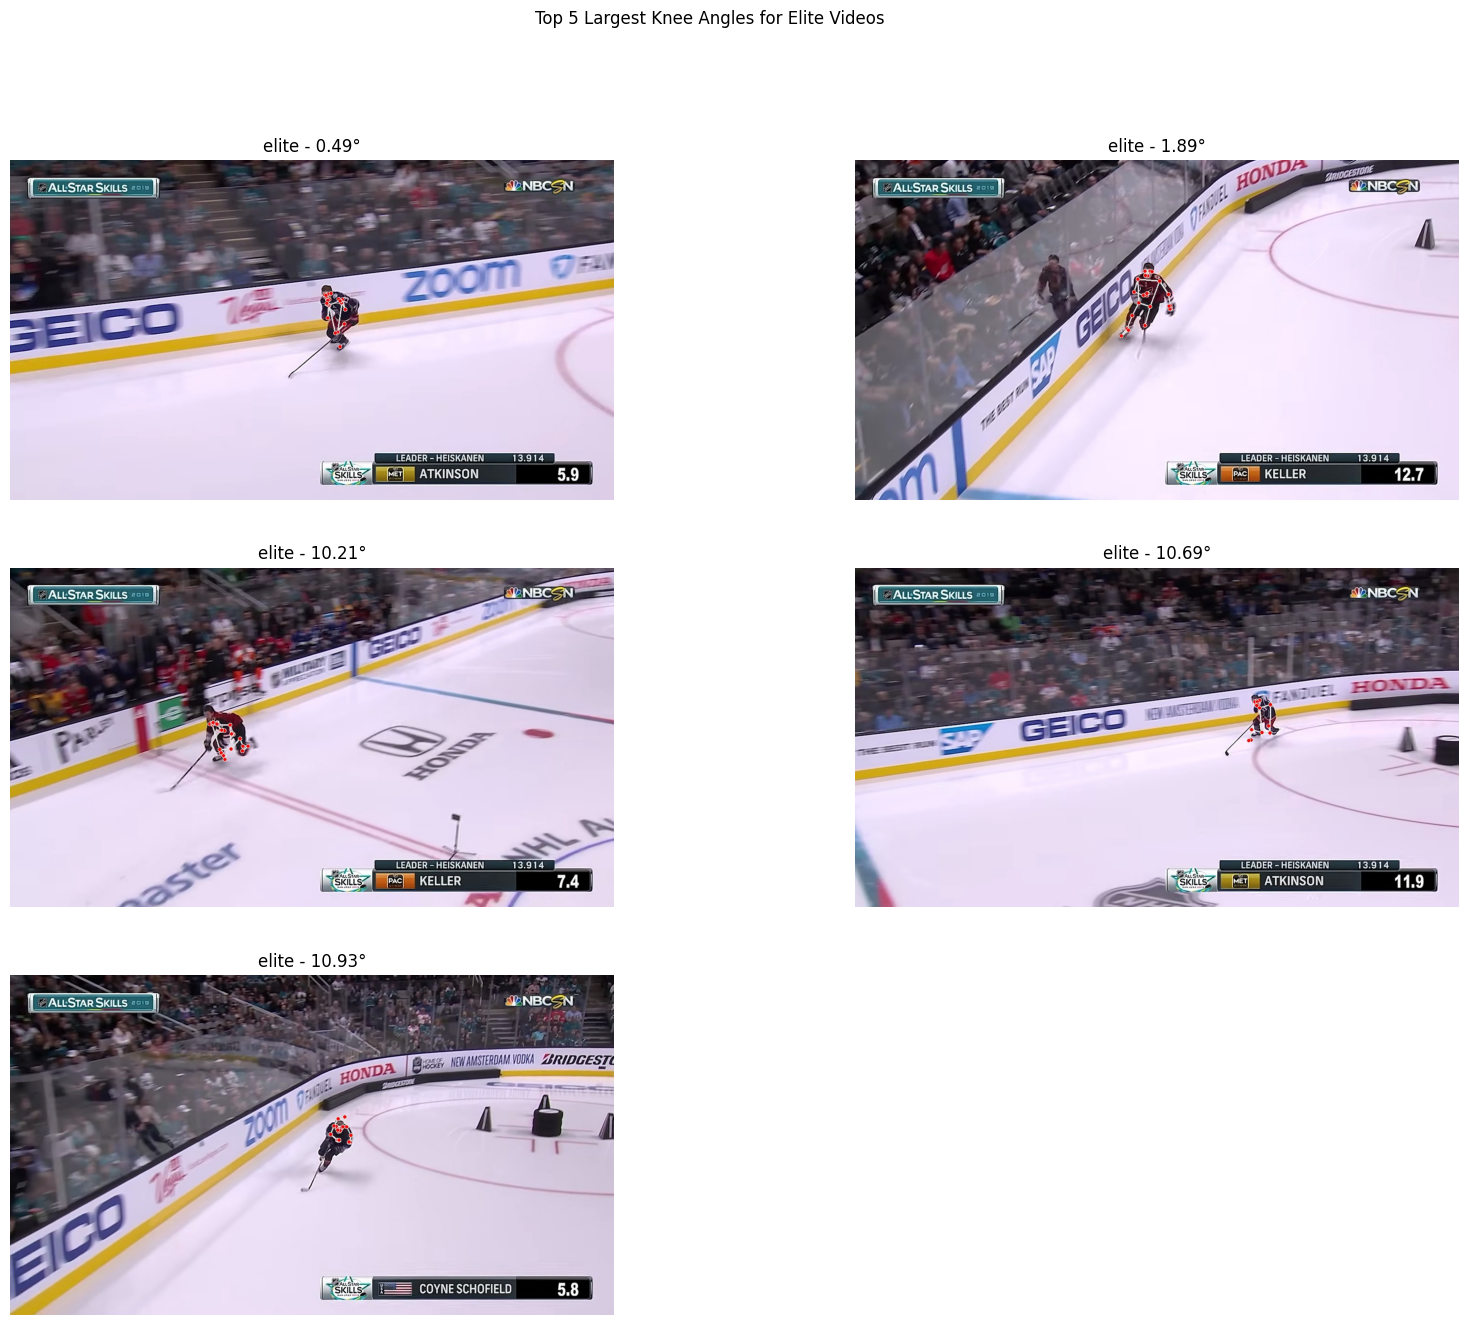

Top 5 Largest Knee Angles for Intermediate Videos:
|    | frame         |   video_id | video_url                                   | video_type   |   duration |   total_frames |   fps |   frame_time |   knee_angle |   stride_length |   hip_stability |   lean_angle |   stride_cadence |   arm_swing_angle |   acceleration |   velocity |   velocity_change |   acceleration_change |   stride_consistency |   cadence_stability |   knee_stability |
|---:|:--------------|-----------:|:--------------------------------------------|:-------------|-----------:|---------------:|------:|-------------:|-------------:|----------------:|----------------:|-------------:|-----------------:|------------------:|---------------:|-----------:|------------------:|----------------------:|---------------------:|--------------------:|-----------------:|
| 19 | frame_150.jpg |          1 | https://www.youtube.com/watch?v=y0wIRVQDbJc | intermediate |     11.645 |            349 | 29.97 |    0.0333667 |      66.2112 

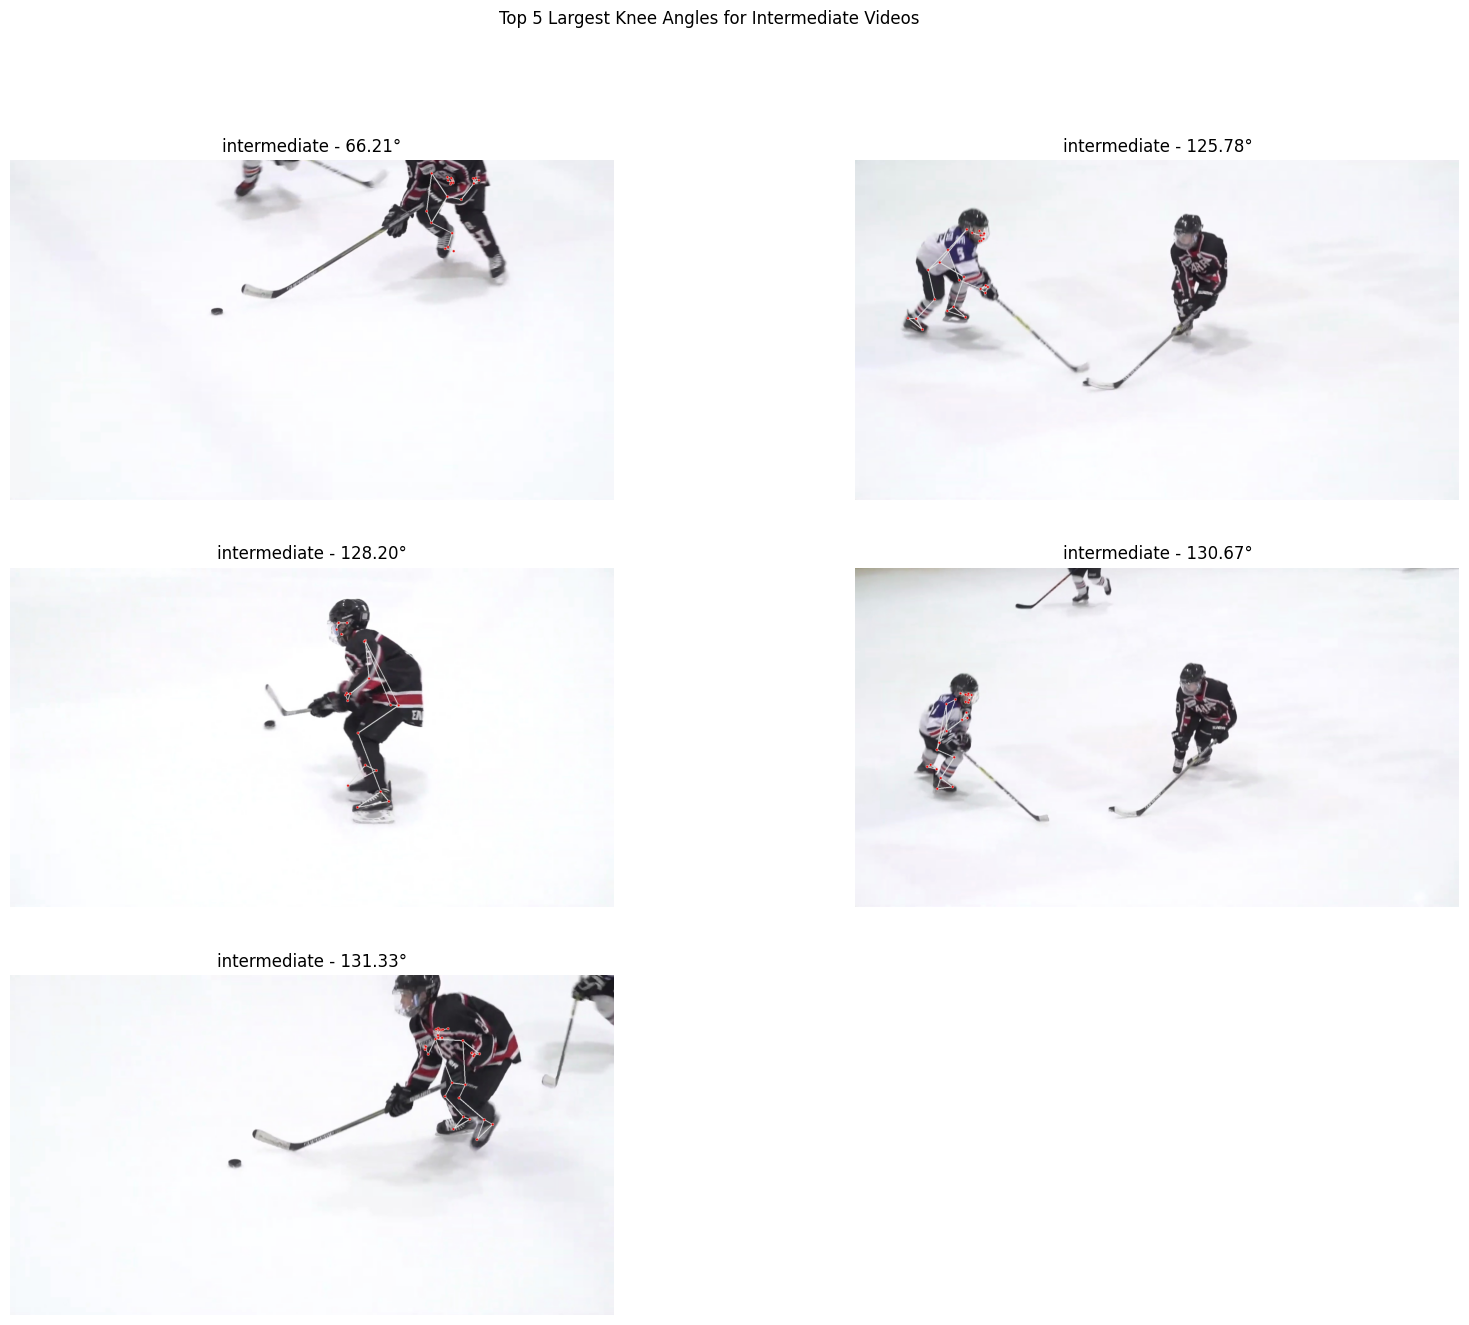

In [138]:
# Filter the top 5 largest knee angles for elite and intermediate video frames
top_elite_knee_angles = df_skating_metrics[df_skating_metrics['video_type'] == 'elite'].nsmallest(5, 'knee_angle')
top_intermediate_knee_angles = df_skating_metrics[df_skating_metrics['video_type'] == 'intermediate'].nsmallest(5, 'knee_angle')

#print and display top_elite_knee_angles
print("Top 5 Largest Knee Angles for Elite Videos:")
print(tabulate(top_elite_knee_angles, headers='keys', tablefmt='pipe'))
display_pose_landmark_images(top_elite_knee_angles, "Top 5 Largest Knee Angles for Elite Videos")

#print and display top_intermediate_knee_angles
print("Top 5 Largest Knee Angles for Intermediate Videos:")
print(tabulate(top_intermediate_knee_angles, headers='keys', tablefmt='pipe'))
display_pose_landmark_images(top_intermediate_knee_angles, "Top 5 Largest Knee Angles for Intermediate Videos")

In [139]:
# Calculate thresholds for labeling skating metrics (good, avg, improve) using elite, intermediate and beginner averages
print("Calculating thresholds for labeling skating metrics...")
thresholds = calculate_thresholds(df_skating_metrics)
print("Thresholds calculated successfully.")

# Label skating metrics dataset based on thresholds
print("Labeling skating metrics dataset based on thresholds...")
labeled_skating_metrics = df_skating_metrics.apply(lambda row: pd.Series(label_skating_metrics(row, thresholds)), axis=1)
print("Skating metrics labeled successfully.")

# Concatenate the original skating metrics with the labeled data
print("Concatenating original skating metrics with labeled data...")
df_skating_metrics = pd.concat([df_skating_metrics, labeled_skating_metrics], axis=1)
print("Concatenation completed successfully.")

# Save labeled dataset
csv_output_path_labels = '../data/skatingmetrics_labeled.csv'
print(f"Saving labeled dataset to {csv_output_path_labels}...")
df_skating_metrics.to_csv(csv_output_path_labels, index=False)
print(f"✅ Skating data labeled successfully! Saved to {csv_output_path_labels}")

# Save label configuration with thresholds to JSON file
print(f"Saving label configuration with thresholds to save for later...")
label_config_filename = '../data/label_config_with_thresholds.json'
label_config_with_thresholds = get_label_config_with_thresholds(thresholds)
label_config_with_thresholds.to_json(label_config_filename, orient='records', lines=True)
print(f"Label configuration with thresholds saved to {label_config_filename}")


Calculating thresholds for labeling skating metrics...
Thresholds calculated successfully.
Labeling skating metrics dataset based on thresholds...
Skating metrics labeled successfully.
Concatenating original skating metrics with labeled data...
Concatenation completed successfully.
Saving labeled dataset to ../data/skatingmetrics_labeled.csv...
✅ Skating data labeled successfully! Saved to ../data/skatingmetrics_labeled.csv
Saving label configuration with thresholds to save for later...
Label configuration with thresholds saved to ../data/label_config_with_thresholds.json


## **Section 4: Data Preprocessing & Feature Engineering** <a id="data_processing"></a>

In [140]:
# Create a copy of games dataset for use in modeling
df_model = df_skating_metrics

In [141]:
#Select input features
X = df_model[['knee_angle', 'stride_length', 'stride_cadence', 'hip_stability', 'lean_angle', 'arm_swing_angle', 'velocity', 'acceleration']]

#Select multi-label target variables
labels = df_model[['knee_angle_label', 'stride_length_label', 'stride_cadence_label', 'hip_stability_label', 'lean_angle_label', 'arm_swing_angle_label', 'velocity_label', 'acceleration_label']]

In [142]:
#Fill missing values with mean
X.fillna(X.mean(), inplace=True)

/var/folders/mj/ndpf249j5rn7jzxyb81srz4w0000gn/T/ipykernel_5397/3167292439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


In [143]:
#Preprocess and filter out columns with constant values because they do not provide any information for classification
X_filtered, labels_filtered = preprocess_and_filter_constant_columns(X, labels)

Unique values per feature:
knee_angle         477
stride_length      477
stride_cadence       6
hip_stability      477
lean_angle         477
arm_swing_angle    477
velocity             1
acceleration       466
dtype: int64
Features after dropping constant value columns:
Index(['knee_angle', 'stride_length', 'stride_cadence', 'hip_stability',
       'lean_angle', 'arm_swing_angle', 'acceleration'],
      dtype='object')
Original dataset size: 477
Filtered dataset size: 477


Z-scores:
[[0.57006324 0.2578557  1.80978945 ... 0.77508159 0.34312045 0.00662048]
 [0.13626043 0.6485089  1.80978945 ... 0.05547008 0.50115718 0.00662048]
 [0.21083469 0.55435302 1.80978945 ... 0.23241571 1.13164327 0.26594397]
 ...
 [0.40253802 0.19438157 2.45871256 ... 0.94461615 0.83910979 0.00662048]
 [0.67162223 1.17346071 2.45871256 ... 0.83262272 1.02996644 0.00662048]
 [0.70779195 0.27109036 2.45871256 ... 0.96624811 0.67781657 0.30243631]]


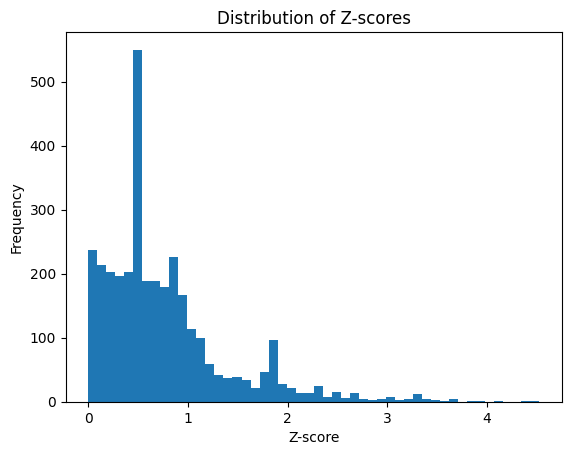

Maximum Z-scores per feature:
[3.9165175  4.11021427 2.45871256 4.5243698  3.38261427 3.39862594
 3.36167025]
Original dataset size: 477
Filtered dataset size with z-score threshold of 3: 439


In [144]:
# Preprocess and filter outlier data using z_scores (# of standard deviations from the mean)
z_score_threshold = 3
X_filtered, labels_filtered = preprocess_and_filter_outlier_data(X_filtered, labels_filtered, z_score_threshold)

The Z-score is a statistical measure that describes a value's relationship to the mean of a group of values. It is measured in terms of standard deviations from the mean. A Z-score indicates how many standard deviations an element is from the mean.

The formula for calculating the Z-score of a value \( x \) is:

\[ Z = \frac{x - \mu}{\sigma} \]

Where:
- \( x \) is the value.
- \( \mu \) is the mean of the dataset.
- \( \sigma \) is the standard deviation of the dataset.

A Z-score can be positive or negative, indicating whether the value is above or below the mean, respectively. 

### Using Z-scores to Filter Out Outliers

Outliers are data points that are significantly different from the rest of the data. Z-scores can be used to identify and filter out these outliers. Typically, a threshold is set (e.g., 3 standard deviations from the mean), and any data points with a Z-score greater than this threshold are considered outliers.

In your code, the Z-scores are calculated for each feature in the dataset `X`, and a threshold of 3 is used to filter out outliers. Here's a step-by-step explanation:

1. **Calculate Z-scores for the features dataset**:
   ```python
   z_scores = np.abs(stats.zscore(X))
   ```
   This calculates the Z-scores for each feature in the dataset `X`. The `np.abs` function is used to get the absolute values of the Z-scores.

2. **Define a threshold for identifying outliers**:
   ```python
   threshold = 3
   ```
   A threshold of 3 is set, meaning any data point with a Z-score greater than 3 is considered an outlier.

3. **Filter out rows where any feature has a Z-score greater than the threshold**:
   ```python
   X_filtered = X[(z_scores < threshold).all(axis=1)]
   ```
   This filters out rows in the dataset `X` where any feature has a Z-score greater than the threshold. The condition `(z_scores < threshold).all(axis=1)` ensures that only rows where all features have Z-scores less than the threshold are kept.

4. **Filter the corresponding rows in the labels dataset**:
   ```python
   labels_filtered = labels.loc[X_filtered.index]
   ```
   This filters the corresponding rows in the labels dataset to match the filtered features dataset.

5. **Print the original and filtered dataset sizes**:
   ```python
   print(f"Original dataset size: {X.shape[0]}")
   print(f"Filtered dataset size: {X_filtered.shape[0]}")
   ```

This process helps in removing outliers from the dataset, which can improve the performance of machine learning models by reducing noise and ensuring that the data is more representative of the underlying patterns.

In [145]:
# Scale features that have different ranges - so that they have mean ~ 0 and std dev ~ 1, ideal for model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)  # Standardizes all numeric features

# Print the shape of the scaled features for debugging
print(f"Shape of X_scaled: {X_scaled.shape}")

# Print the first few rows of the scaled features for debugging
print("First few rows of X_scaled:")
print(X_scaled[:5])

Shape of X_scaled: (439, 7)
First few rows of X_scaled:
[[ 0.56739517  0.26707498 -1.82801415 -0.45555476  0.81391862  0.4038876
   0.02432772]
 [-0.33508415  0.67064611 -1.82801415 -0.19530629 -0.08736558  0.5734317
   0.02432772]
 [-0.43036869  0.57337673 -1.82801415 -0.57140788 -0.44793083  1.24982633
  -0.26003378]
 [ 0.24320236 -0.54831275 -1.82801415 -0.0611734   0.70249448  0.99731411
   0.31002433]
 [-0.40394935  0.65439162 -1.82801415  0.92748161 -0.48999721 -0.3948011
  -0.05171394]]


In [146]:
# Convert labels to numerical categories
print("Converting labels to numerical categories for progress and debug...")
labels_filtered = labels_filtered.apply(lambda x: x.astype("category").cat.codes)
print("Labels converted successfully. Here are the first few rows:")
print(labels_filtered.head())

Converting labels to numerical categories for progress and debug...
Labels converted successfully. Here are the first few rows:
   knee_angle_label  stride_length_label  stride_cadence_label  \
0                 2                    1                     0   
1                 1                    1                     0   
2                 1                    1                     0   
3                 2                    0                     0   
4                 1                    1                     0   

   hip_stability_label  lean_angle_label  arm_swing_angle_label  \
0                    0                 0                      0   
1                    0                 1                      0   
2                    0                 1                      1   
3                    0                 0                      1   
4                    1                 1                      2   

   velocity_label  acceleration_label  
0               0               

In [147]:
#Split data between training set (80% of X) and validation/testing set (20% of X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels_filtered, test_size=0.2, random_state=42)


## **Section 5: Model 1 - Multi-Label Classifier: Random Forest** <a id="mlc_rf_model"></a>

### **Section 5a: Train a Model** <a id="mlc_rf_train"></a> ###

In [148]:
# Train multi-label model
rf_model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
rf_model.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42))

### **Section 5b: Evaluate/Test a Model** <a id="mlc_rf_eval"></a> ###

In [149]:
# Predict on test set
y_pred = rf_model.predict(X_test)

In [150]:
# Evaluate model accuracy for each label
for i, label in enumerate(labels.columns):
    acc = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"{label} Accuracy: {acc:.2f}")

knee_angle_label Accuracy: 1.00
stride_length_label Accuracy: 1.00
stride_cadence_label Accuracy: 1.00
hip_stability_label Accuracy: 0.99
lean_angle_label Accuracy: 1.00
arm_swing_angle_label Accuracy: 1.00
velocity_label Accuracy: 1.00
acceleration_label Accuracy: 1.00


## **Section 6: Model 2 - Multi-Label Classifer with xGBoost** <a id="mlc_xgb_model"></a> ##

### **Section 6a: Train a Model** <a id="mlc_rf_train"></a> ###

In [151]:
# Train multi-label model
xgb_model = MultiOutputClassifier(xgb.XGBClassifier(n_estimators=100, max_depth=5, use_label_encoder=False, eval_metric='mlogloss'))
xgb_model.fit(X_train, y_train)

/Users/liammckendry/Project3_NHL_Videos/venv310/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:34:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))

### **Section 6b: Evaluate/Test a Model** <a id="mlc_xgb_eval"></a> ###

In [152]:
# Predict on test set
y_pred = xgb_model.predict(X_test)

In [153]:
# Evaluate model accuracy for each label
for i, label in enumerate(labels.columns):
    acc = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"{label} Accuracy: {acc:.2f}")

knee_angle_label Accuracy: 1.00
stride_length_label Accuracy: 1.00
stride_cadence_label Accuracy: 1.00
hip_stability_label Accuracy: 0.99
lean_angle_label Accuracy: 1.00
arm_swing_angle_label Accuracy: 1.00
velocity_label Accuracy: 1.00
acceleration_label Accuracy: 1.00


## **Section 7: Model 3 - Multi Label Classifier with Neural Network**<a id="mlc_nn"></a> ##

### **Section 7a: Train a Model** <a id="mlc_nn_train"></a> ###

In [154]:
# Train multi-label model
nn_model = MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500, random_state=42))
nn_model.fit(X_train, y_train)

MultiOutputClassifier(estimator=MLPClassifier(hidden_layer_sizes=(100, 50),
                                              max_iter=500, random_state=42))

### **Section 7b: Evaluate/Test a Model** <a id="mlc_nn_eval"></a> ###

In [155]:
# Predict on test set
y_pred = nn_model.predict(X_test)

In [156]:
# Evaluate model accuracy for each label
for i, label in enumerate(labels.columns):
    acc = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"{label} Accuracy: {acc:.2f}")

knee_angle_label Accuracy: 0.94
stride_length_label Accuracy: 0.95
stride_cadence_label Accuracy: 0.93
hip_stability_label Accuracy: 0.98
lean_angle_label Accuracy: 0.94
arm_swing_angle_label Accuracy: 0.93
velocity_label Accuracy: 1.00
acceleration_label Accuracy: 0.92


### **Section 7.3: Save Model** <a id="save_model"></a> ###

In [157]:
# Save the model to a file
with open("../src/models/skating_ai_model.pkl", "wb") as model_file:
    pickle.dump(nn_model, model_file)

# we also need to save how the model is scaling input data so we can apply the same method in the application
#If your app (eg Flask API) does not scale the input data the same way as during training, predictions will be off.

# Check how your model was trained (re-do from Section 5c)
scaler = StandardScaler()
X_scaled_filtered = scaler.fit_transform(X_filtered)

# Save the scaler for API use
joblib.dump(scaler, "../src/models/scaler.pkl")

['../src/models/scaler.pkl']

## **Archive: Load & Save Data (Online Only)** <a id="data_load_archive"></a>

In [ ]:
# Load the skating videos & extra frames

# Set parameters for skating data
skating_video_url_list = [
    {"url": "https://www.youtube.com/watch?v=y0wIRVQDbJc", "type": "amateur"},
    {"url": "https://www.youtube.com/watch?v=7jOCmk17dsc", "type": "elite"},
    {"url": "https://www.youtube.com/watch?v=ZyqPV_yLKoI", "type": "elite"}
]  # List of skating video URL and type (elite, intermediate, beginner)
video_output_dir = "../data"  # Output directory to save video frames
frame_interval = 10 # Interval to extract frames (in seconds)
skating_metrics = [
    "knee_angle",
    "stride_length",
    "stride_cadence",
    "hip_stability",
    "lean_angle",
    "arm_swing_angle",
    "velocity", 
    "acceleration"
]  # Skating metrics to calculate
csv_output_path_metrics = "../data/metrics_output.csv" # Path to save the output CSV file
csv_output_path_labels = "../data/labeled_skating_data.csv" # Path to save the labeled skating data

In [ ]:
# Load and process skating videos from online if saving metrics not saved already in csv
if os.path.exists(csv_output_path_metrics):
    print("📂 Skating metrics CSV file found! Loading from saved file...")
    df_skating_metrics = pd.read_csv(csv_output_path_metrics) # read & load existing skating metrics
    urls_to_process, current_video_count = checkForNewVideos(skating_video_url_list,df_skating_metrics) # check if any new videos added
    if urls_to_process:  #if yes, add process new videos and add to csv file
        print("🌍 Some videos are not processed yet. Fetching and processing new videos...")
        new_metrics = process_videos(urls_to_process, video_output_dir, frame_interval, skating_metrics, start_index=current_video_count + 1)
        df_skating_metrics = pd.concat([df_skating_metrics, new_metrics], ignore_index=True)
        df_skating_metrics.to_csv(csv_output_path_metrics, index=False)  # Save for future use
    print("Skating metrics loaded successfully!")
else:
    print("🌍 Skating metrics CSV file not found. Fetching skating videos from online...")
    df_skating_metrics = process_videos(skating_video_url_list, video_output_dir, frame_interval, skating_metrics, start_index=1)
    df_skating_metrics.to_csv(csv_output_path_metrics, index=False)  # Save for future use
    print(f"Skating metrics saved successfully! Saved to {csv_output_path_metrics}")

📂 Skating metrics CSV file found! Loading from saved file...
🌍 Some videos are not processed yet. Fetching and processing new videos...
Processing video 3/1: https://www.youtube.com/watch?v=ZyqPV_yLKoI
[youtube] Extracting URL: https://www.youtube.com/watch?v=ZyqPV_yLKoI
[youtube] ZyqPV_yLKoI: Downloading webpage
[youtube] ZyqPV_yLKoI: Downloading tv client config
[youtube] ZyqPV_yLKoI: Downloading player b21600d5
[youtube] ZyqPV_yLKoI: Downloading tv player API JSON
[youtube] ZyqPV_yLKoI: Downloading ios player API JSON
[youtube] ZyqPV_yLKoI: Downloading m3u8 information
[info] ZyqPV_yLKoI: Downloading 1 format(s): 398+251
[download] Destination: ../data/video_3.f398.mp4
[download] 100% of  160.84MiB in 00:00:39 at 4.07MiB/s     
[download] Destination: ../data/video_3.f251.webm
[download] 100% of    6.00MiB in 00:00:01 at 3.36MiB/s   
[Merger] Merging formats into "../data/video_3.mp4"
Deleting original file ../data/video_3.f398.mp4 (pass -k to keep)
Deleting original file ../data/vi

I0000 00:00:1741812100.235074 2723064 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1741812100.299099 2733655 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741812100.310773 2733655 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741812100.323414 2733657 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Pose landmarks for video_3 saved to: ../data/pose_output_3.  Number of pose estimates: 2004
Video information added for video 3/1
Initiating metrics calculation...
shape of video_info: {'url': 'https://www.youtube.com/watch?v=ZyqPV_yLKoI', 'type': 'elite', 'video_id': 'video_3', 'duration': 535.1012333333333, 'total_frames': 32074, 'fps': 59.94005994005994}
An error occurred while processing video 3/1: Landmark positions must be non-negative
Metrics:
Empty DataFrame
Columns: []
Index: []
Skating metrics loaded successfully!


In [ ]:
# Apply labeling function to each skating metric based on thresholds (e.g. good / OK / need improvement)
labeled_data = df_skating_metrics.apply(label_skating_metrics, axis=1, result_type="expand")

# Concatenate the original skating metrics with the labeled data
df_skating_metrics = pd.concat([df_skating_metrics, labeled_data], axis=1)

# Save labeled dataset
df_skating_metrics.to_csv(csv_output_path_labels, index=False)
print(f"✅ Skating data labeled successfully! Saved to {csv_output_path_labels}")


✅ Skating data labeled successfully! Saved to ../data/labeled_skating_data.csv
